# 0.0. IMPORTS

In [3]:
import datetime
import pickle
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Image, display
from scipy.stats import chi2_contingency
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer






In [2]:
plt.style.use('estilos/personalestilo.mplstyle')


Bad key axes.color_cycle in file estilos/personalestilo.mplstyle, line 9 ('axes.color_cycle: df691b, 5cb85c, 5bc0de, f0ad4e, d9534f, 4e5d6c')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.10.6/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution


## 0.1. Helper Functions

In [3]:
def snake_case(lst):
    """
    Recebe uma lista de strings e retorna uma nova lista no formato snake_case.
    """
    def convert(s):
        s = s.replace(' ', '_')
        new_s = ""
        for i, c in enumerate(s):
            if c.isupper():
                if i > 0 and (s[i-1].islower() or (i+1 < len(s) and s[i+1].islower())):
                    new_s += "_"
                new_s += c.lower()
            else:
                new_s += c
        return new_s

    return [convert(s) for s in lst]

# Avaliação do MPE (Mean Percentage Error) do modelo
def mean_percentage_error(y_true, y_pred):
    """Calcula o erro percentual médio (MPE)."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((y_true - y_pred) / y_true) * 100


def cramers_v_bias_corrected(confusion_matrix):
    """Calcula o V de Cramer (correto para bias) dado uma tabela de contingência."""
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    phi2 = chi2 / n
    # bias correction
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    denominator = min((kcorr-1), (rcorr-1))
    if denominator == 0:
        return np.nan
    return np.sqrt(phi2corr / denominator)

def calcular_metricas(y_true, y_pred, nome_modelo="modelo"):
    """
    Calcula e retorna as principais métricas de avaliação de modelos de regressão em um DataFrame.
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    df_metricas = pd.DataFrame({
        'modelo': [nome_modelo],
        'rmse': [rmse],
        'mae': [mae],
        'mape': [mape],
        'r2': [r2]
    })
    return df_metricas

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    """
    Executa cross-validation usando método de validation por janela de tempo.
    Assumindo intervalos fixos de 6 semanas como janelas de validação.

    Parâmetros:
        x_training (DataFrame): dados de treino, deve conter as colunas 'date' e 'sales'.
        kfold (int): número de folds (partições de janela de tempo, ex: 5).
        model_name (str): nome do modelo.
        model: objeto modelo sklearn (ou similar), já instanciado.
        verbose (bool): se True, imprime informações do fold.

    Retorno:
        DataFrame com médias/STD de MAE, MAPE, RMSE e R2 para todos os folds.
    """
    mae_list = []
    mape_list = []
    rmse_list = []
    r2_list = []

    window_days = 6 * 7
    if not np.issubdtype(x_training['date'].dtype, np.datetime64):
        x_training = x_training.copy()
        x_training['date'] = pd.to_datetime(x_training['date'])

    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        max_date = x_training['date'].max()
        validation_start_date = max_date - pd.Timedelta(days=k*window_days)
        validation_end_date = max_date - pd.Timedelta(days=(k-1)*window_days)
        
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        
        if len(training) == 0 or len(validation) == 0:
            if verbose:
                print("Skipping fold {} (not enough data)".format(k))
            continue

        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']


        m = model.fit(xtraining, ytraining)
        yhat = m.predict(xvalidation)

        y_true = np.expm1(yvalidation)
        y_pred = np.expm1(yhat)

        mae_value = mean_absolute_error(y_true, y_pred)
        mape_value = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1, y_true))) * 100
        mse_value = mean_squared_error(y_true, y_pred)
        rmse_value = np.sqrt(mse_value)
        r2_value = r2_score(y_true, y_pred)

        mae_list.append(mae_value)
        mape_list.append(mape_value)
        rmse_list.append(rmse_value)
        r2_list.append(r2_value)
    df_result = pd.DataFrame({
        'Model Name': [model_name],
        'MAE CV': [str(np.round(np.mean(mae_list), 2)) + ' +/- ' + str(np.round(np.std(mae_list), 2))],
        'MAPE CV': [str(np.round(np.mean(mape_list), 2)) + ' +/- ' + str(np.round(np.std(mape_list), 2))],
        'RMSE CV': [str(np.round(np.mean(rmse_list), 2)) + ' +/- ' + str(np.round(np.std(rmse_list), 2))],
        'R2 CV': [str(np.round(np.mean(r2_list), 4)) + ' +/- ' + str(np.round(np.std(r2_list), 4))]
    })
    return df_result


## 0.2. Loading data

In [5]:
df_sales_raw = pd.read_csv('database/train.csv', low_memory=False)
df_store_raw = pd.read_csv('database/store.csv', low_memory=False)

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')



# 1.0. DESCRICAO DOS DADOS

In [5]:
df1 = df_raw

## 1.1. Rename Columns

In [6]:
cols_old = list(df_raw.columns)

cols_new = snake_case(cols_old)

df1.columns = cols_new

## 1.2. Data Dimensions

In [7]:
print('Number of rows:', df1.shape[0])
print('Number of columns:', df1.shape[1])

Number of rows: 1017209
Number of columns: 18


## 1.3 Data Types

In [8]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [9]:
df1['date'] = pd.to_datetime(df1['date'])



## 1.4 Check NA

In [10]:
print(df1.isna().sum())


store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64


## 1.6 Fillout NA

In [11]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].fillna(200000)

#competition_open_since_month
df1['competition_open_since_month'] = df1['competition_open_since_month'].fillna(df1['date'].dt.month)

#competition_open_since_year
df1['competition_open_since_year'] = df1['competition_open_since_year'].fillna(df1['date'].dt.year)         

#promo2_since_week
df1['promo2_since_week'] = df1['promo2_since_week'].fillna(df1['date'].dt.isocalendar().week)

#promo2_since_year  
df1['promo2_since_year'] = df1['promo2_since_year'].fillna(df1['date'].dt.year)   

#promo_interval 
df1['promo_interval'] = df1['promo_interval'].fillna(0)
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1.apply(lambda row: 1 if str(row['month_map']) in str(row['promo_interval']) else 0, axis=1)
df1.drop('month_map', axis=1, inplace=True)



In [12]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [13]:
print(df1.isna().sum())

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
is_promo                        0
dtype: int64


## 1.6. Descriptive Statistical

In [14]:
df_numeric = df1.select_dtypes(include=['int64', 'float64'])

df_categorical = df1.select_dtypes(include=['object'])



### 1.6.1 Numerical Attributes

In [15]:
numerical_stats = pd.DataFrame({
    'mean': df_numeric.mean(),
    'median': df_numeric.median(),
    'std': df_numeric.std(),
    'min': df_numeric.min(),
    'max': df_numeric.max(),
    'range': df_numeric.max() - df_numeric.min(),
    'skew': df_numeric.skew(),
    'kurtosis': df_numeric.kurt()
})

display(numerical_stats)


,mean,median,std,min,max,range,skew,kurtosis
store,558.429727,558.0,321.908651,1.0,1115.0,1114.0,-0.000955,-1.200524
day_of_week,3.998341,4.0,1.997391,1.0,7.0,6.0,0.001593,-1.246873
sales,5773.818972,5744.0,3849.926175,0.0,41551.0,41551.0,0.641460,1.778375
customers,633.145946,609.0,464.411734,0.0,7388.0,7388.0,1.598650,7.091773
open,0.830107,1.0,0.375539,0.0,1.0,1.0,-1.758045,1.090723
promo,0.381515,0.0,0.485759,0.0,1.0,1.0,0.487838,-1.762018
school_holiday,0.178647,0.0,0.383056,0.0,1.0,1.0,1.677842,0.815154
competition_distance,5935.442677,2330.0,12547.652996,20.0,200000.0,199980.0,10.242344,147.789712
competition_open_since_month,6.786849,7.0,3.311087,1.0,12.0,11.0,-0.042076,-1.232607
competition_open_since_year,2010.324840,2012.0,5.515593,1900.0,2015.0,115.0,-7.235657,124.071304


### 1.6.2 Categorical Attributes

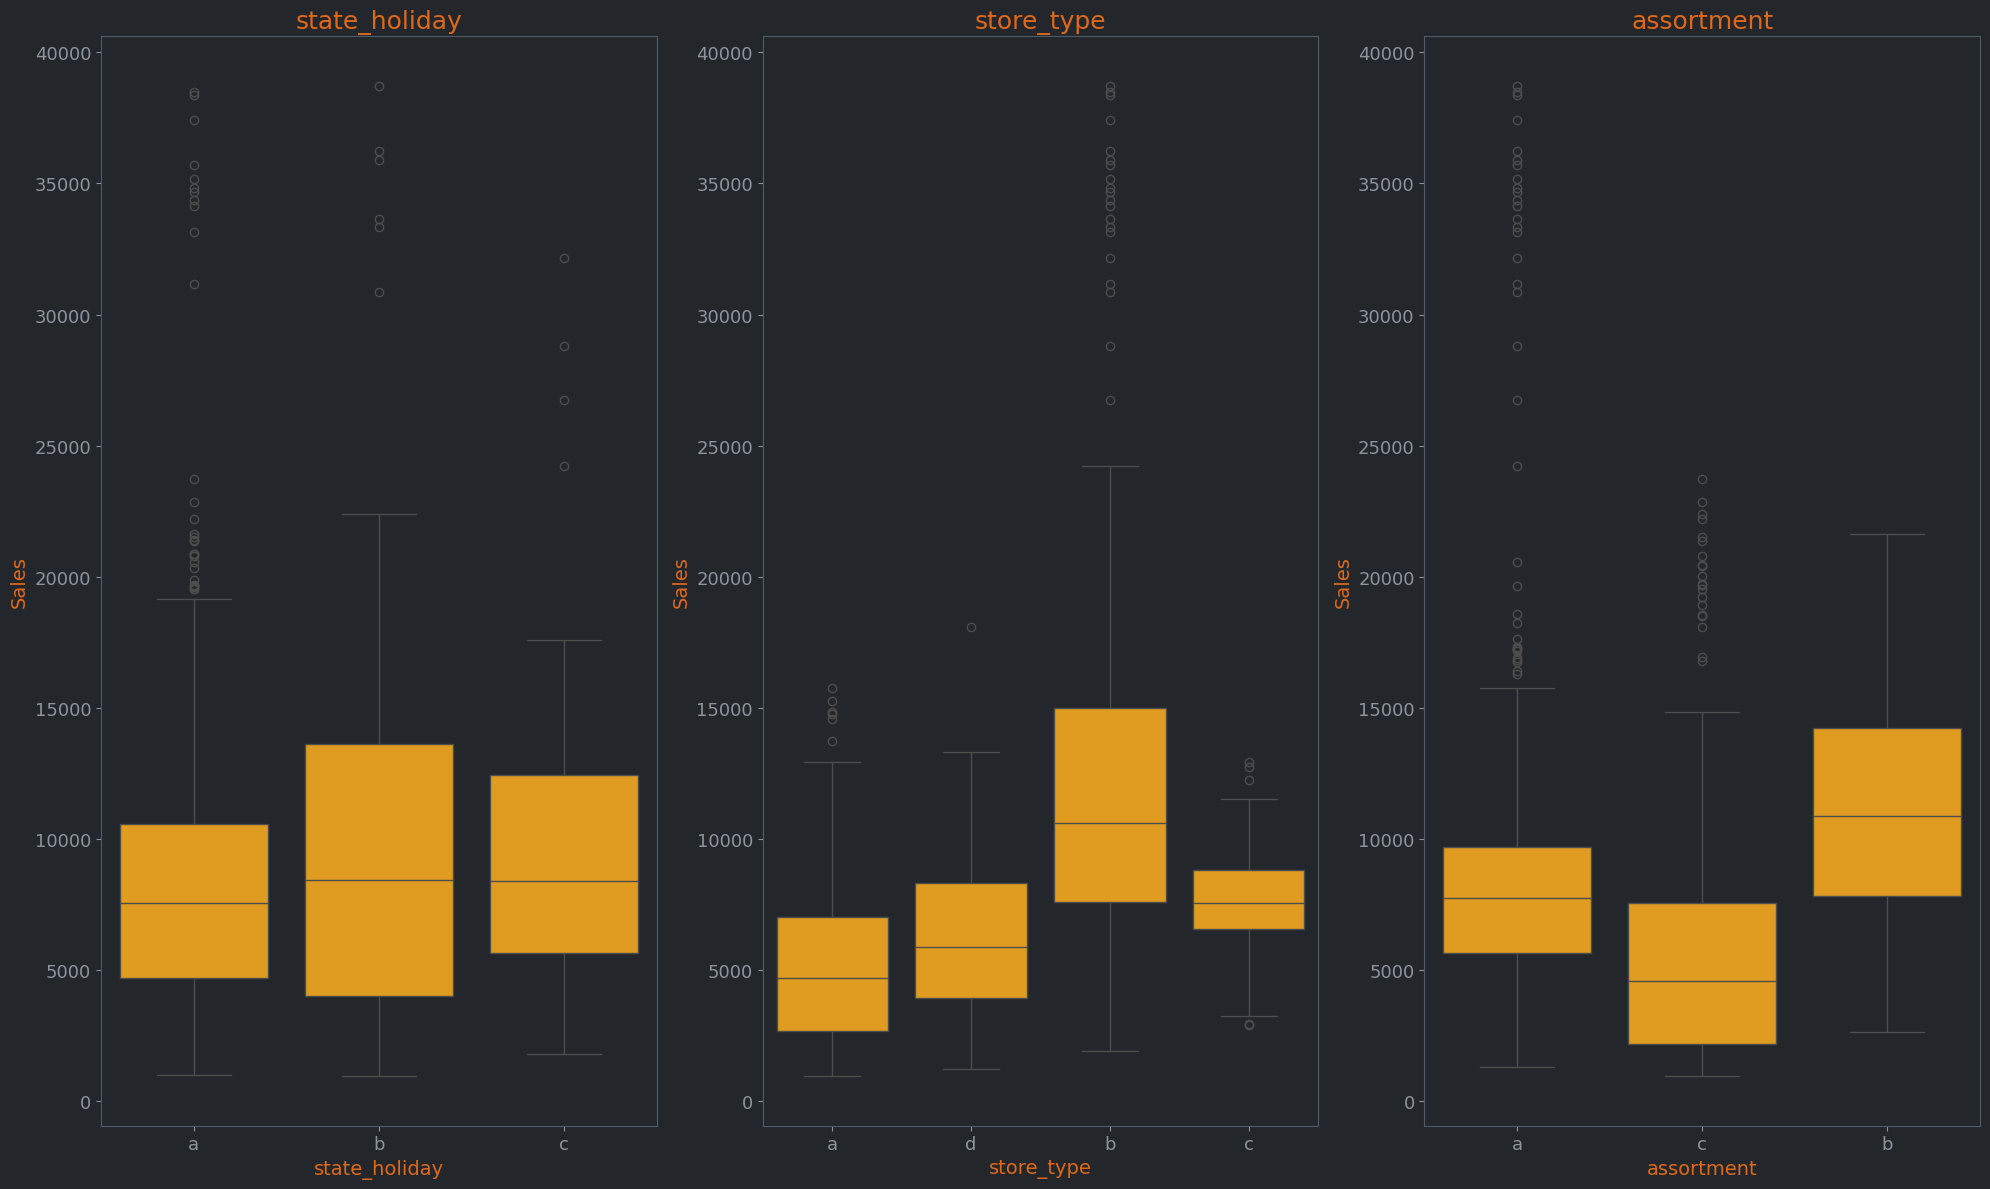

In [16]:
plt.figure(figsize=(20, 12))

# Filtrar apenas os dias com vendas maiores que 0 e state_holiday diferente de 0
df_sales_positive = df1[(df1['sales'] > 0) & (df1['state_holiday'] != '0')]

categorical_columns = [col for col in df1.select_dtypes(include=['object']).columns if col != 'promo_interval']

for idx, col in enumerate(categorical_columns, 1):
    plt.subplot(1, len(categorical_columns), idx)
    sns.boxplot(x=col, y='sales', data=df_sales_positive, color='orange')
    plt.title(f'{col}', fontsize=18)
    plt.xlabel(col, fontsize=14)
    plt.ylabel('Sales', fontsize=14)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)

plt.tight_layout()
plt.show()


# 2.0 FEATURE ENGINEERING

In [17]:
df2 = df1

## 2.1 Mapa Mental de Hipóteses

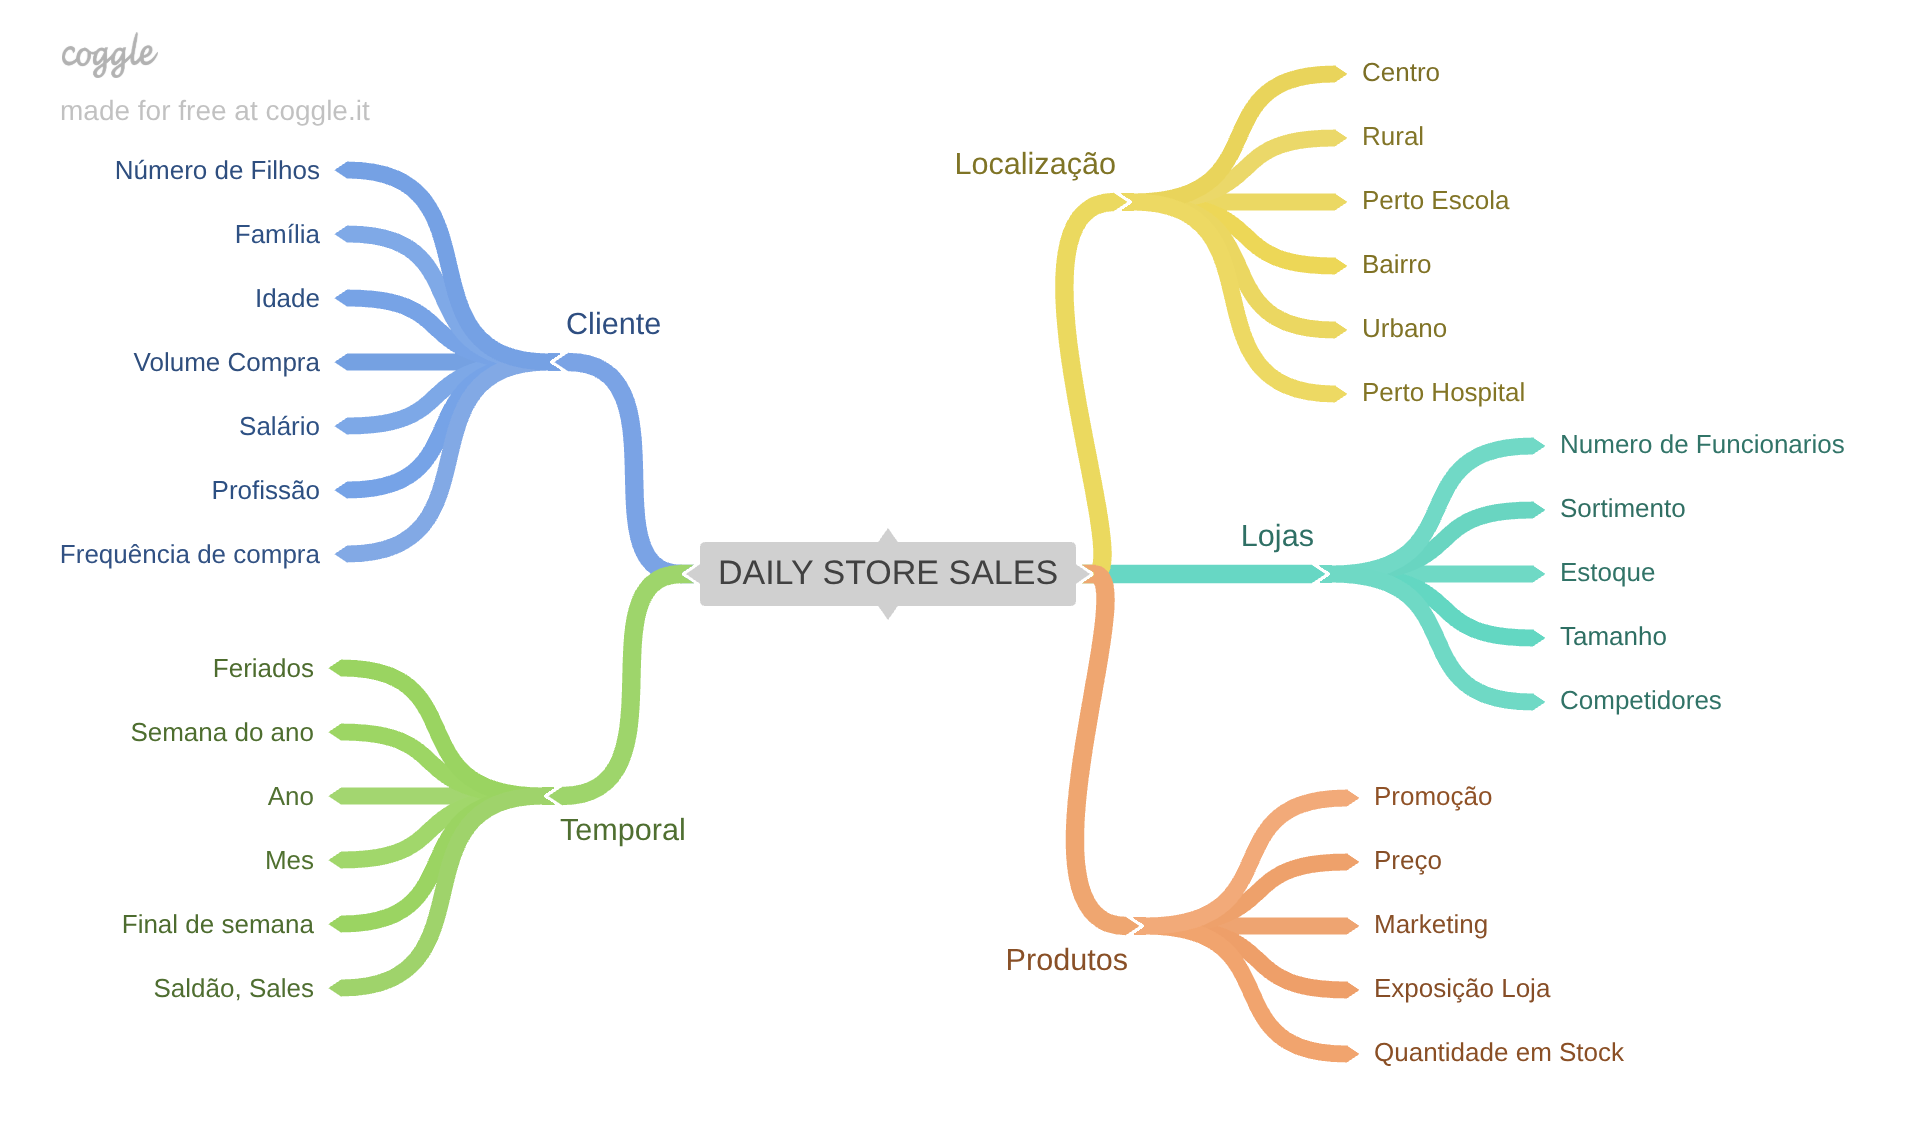

In [18]:
# Para inserir uma imagem no notebook, use o seguinte comando:
display(Image(filename='images/DAILY_STORE_SALES.png'))

## 2.2 Criação de Hipoteses

### 2.2.1 Hipoteses Loja

- Lojas de maior porte deveriam vender mais.

- Lojas com Maior sortimento deveriam vender mais.

- Lojas com competidores mais próximos deveriam vender menos.

- Lojas com maior estoque deveriam vender mais.

- Lojas com maior número de funcionários deveriam vender mais.

- Lojas com competidores a mais tempo deveriam vender mais.

### 2.2.2 Hipoteses Produto

- Lojas que investem mais em marketing deveriam vender mais

- Lojas com promoções mais agressivas deveriam vender mais.

- Lojas com maior exposição do produto deveriam vender mais.

- Lojas com promoções ativas por mais tempo deveriam vender mais.

- Lojas com mais dias de promoção deveriam vender mais.

- Lojas com mais promoções consecutivas deveriam vender mais.

- Lojas com produtos com maior preço deveriam vender menos.



### 2.1.3 Hipoteses Tempo

- Lojas abertas durante o feriado de natal deveriam vender mais.

- Lojas deveriam vender mais ao longo dos anos.

- Lojas deveriam vender mais no segundo semestre do ano.

- Lojas deveriam vender mais depois do dia 10 de cada mês.

- Lojas deveriam vender menos no final de semana.

- Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Lista Final de Hipóteses

- Lojas com Maior sortimento deveriam vender mais.

- Lojas com competidores mais próximos deveriam vender menos.

- Lojas com competidores a mais tempo deveriam vender mais.

- Lojas com promoções ativas por mais tempo deveriam vender mais.

- Lojas com mais dias de promoção deveriam vender mais.

- Lojas com mais promoções consecutivas deveriam vender mais.

- Lojas abertas durante o feriado de natal deveriam vender mais.

- Lojas deveriam vender mais ao longo dos anos.

- Lojas deveriam vender mais no segundo semestre do ano.

- Lojas deveriam vender mais depois do dia 10 de cada mês.

- Lojas deveriam vender menos no final de semana.

- Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Feature Engineering

In [19]:
# Criar coluna 'year' como numérica
df2['year'] = df2['date'].dt.year.astype(int)

# Criar coluna 'month' como numérica
df2['month'] = df2['date'].dt.month.astype(int)

# Criar coluna 'day' como numérica
df2['day'] = df2['date'].dt.day.astype(int)

# Criar coluna 'week_of_year' como numérica
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype(int)


df2['competition_since'] = pd.to_datetime(
    dict(
        year=df2['competition_open_since_year'],
        month=df2['competition_open_since_month'],
        day=1
    )
)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']).dt.days / 30).round().astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(int).astype(str) + '-' + df2['promo2_since_week'].astype(int).astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# transformar valores em 'assortment': 'a' -> 'basic', 'b' -> 'extra', 'c' -> 'extended'
df2['assortment'] = df2['assortment'].map({'a': 'basic', 'b': 'extra', 'c': 'extended'})

# transformar valores em 'state_holiday': 'a' -> 'public holiday', 'b' -> 'easter holiday', 'c' -> 'christmas', '0' -> 'regular_day'
df2['state_holiday'] = df2['state_holiday'].map({'a': 'public holiday', 'b': 'easter holiday', 'c': 'christmas', '0': 'regular_day'})


# 3.0 FILTRAGEM DE VARIÁVEIS

In [20]:
df3 = df2

## 3.1 Filtragem das linhas

In [21]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Filtragem das colunas

In [22]:
df3 = df3.drop(['customers', 'open', 'promo_interval'], axis=1)

# 4.0 ANALÍSE EXPLORATÓRIA DOS DADOS

In [23]:
df4 = df3

## 4.1 Analise Univariada

### 4.1.1 Response Variable

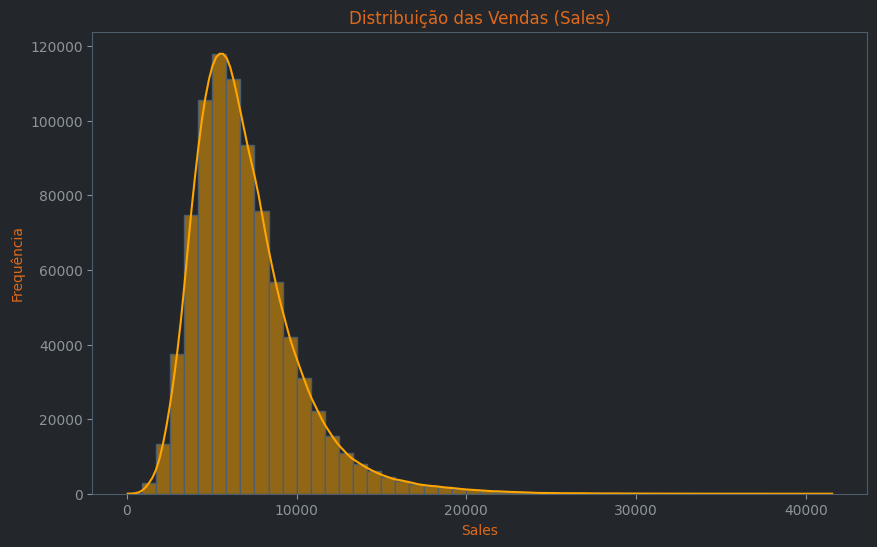

In [24]:
plt.figure(figsize=(10,6))
sns.histplot(df4['sales'], kde=True, bins=50, color='orange')
plt.title('Distribuição das Vendas (Sales)')
plt.xlabel('Sales')
plt.ylabel('Frequência')
plt.show()


### 4.1.2 Numerical Variables

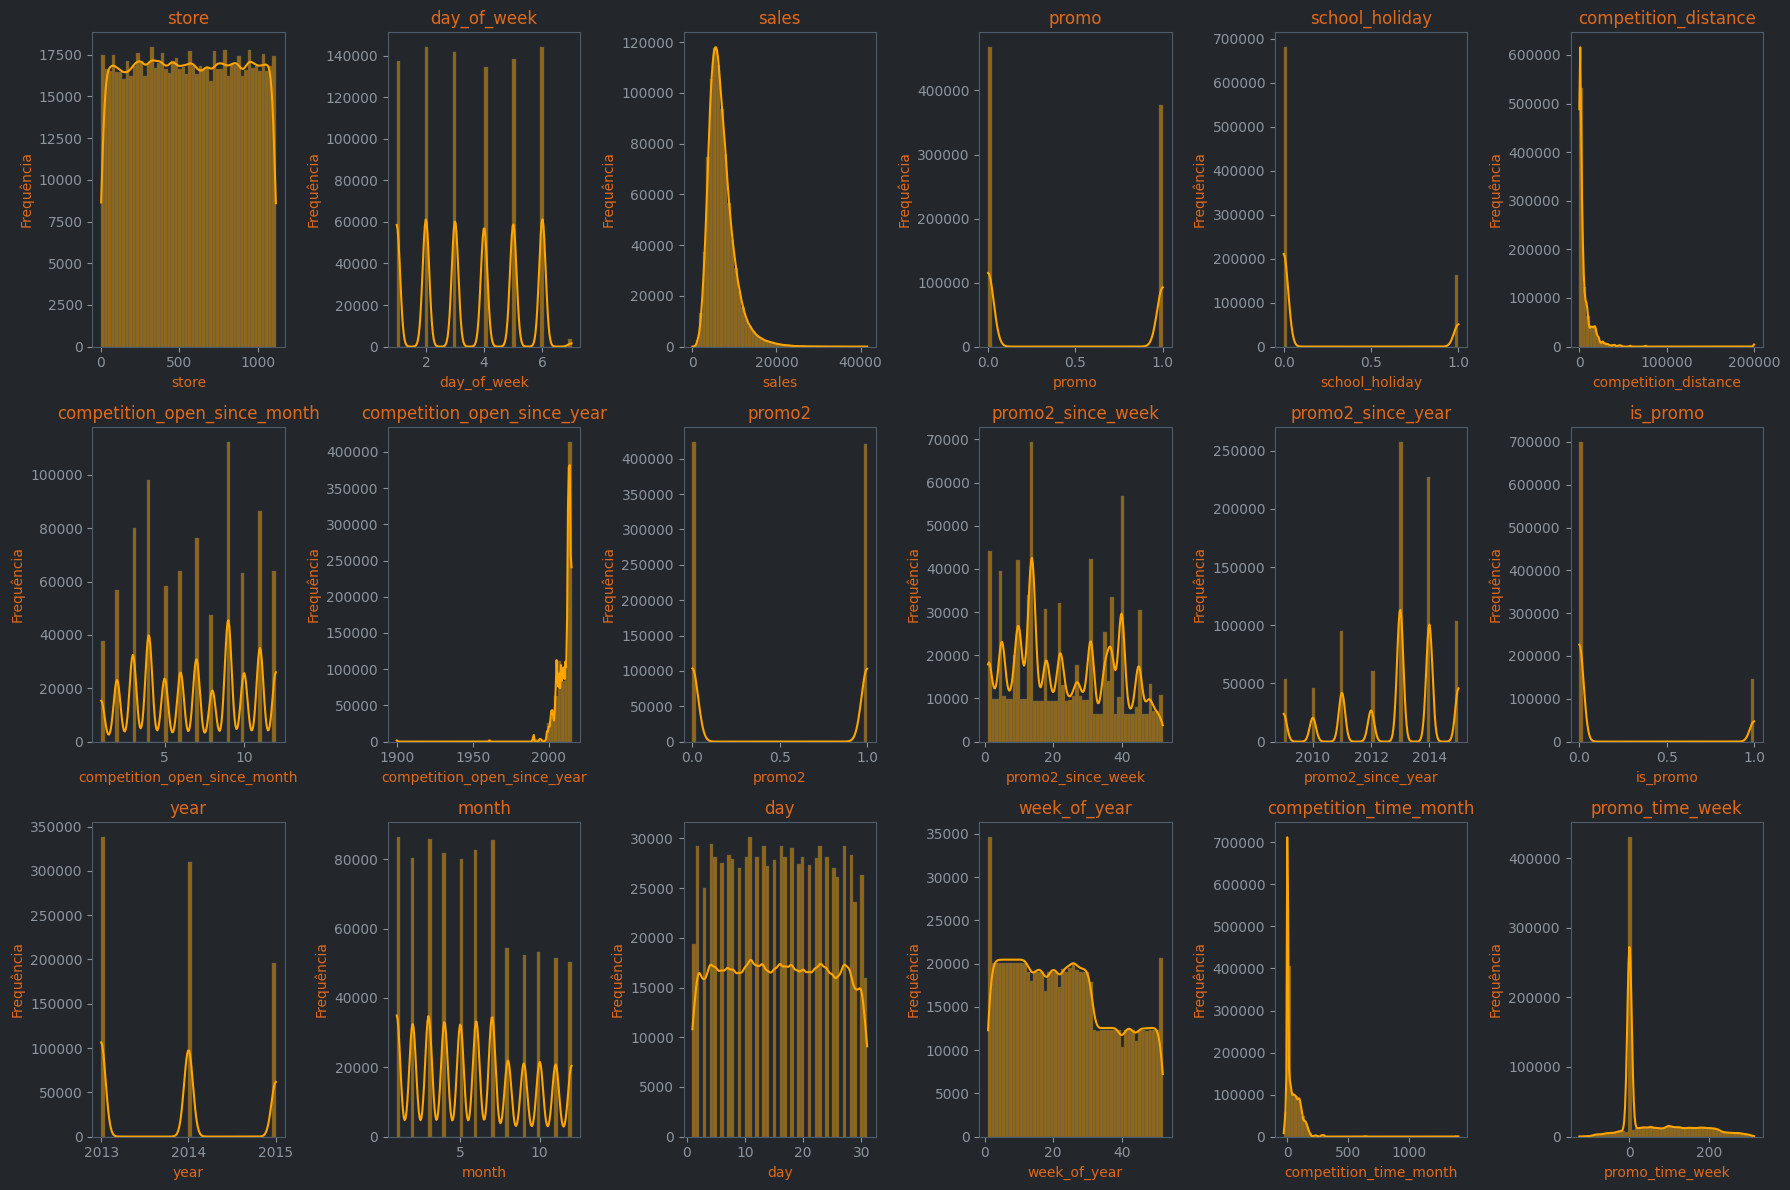

In [25]:
numerical_cols = df4.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(18, 12))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, int(np.ceil(len(numerical_cols)/3)), i)
    sns.histplot(df4[col], bins=50, kde=True, color='orange')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Frequência')
plt.tight_layout()
plt.show()


Store pode conter comportamento específico, então ela é importante, mas não como variável numérica, pois no gráfico não é possível ver qualquer relação com as vendas


day_of_week não parece ter muita diferença para cada valor.


Promo, há uma quantidade um pouco maior de vendas quando não tem promoção no dia, mas algumas lojas de grande volume vendem muito mesmo sem promoções, e também há muitas lojas com Promo=0, o que distorce a média.


School holyday, há mais vendas quando não tem feriado escolar. 


Competition distance, parece haver mais vendas quando a distância da competidora é menor. Pode indicar: Que a loja está em área de alto movimento e, por isso, tem mais concorrentes e mais vendas. Que lojas em grandes cidades competem mais e vendem mais

Competition open since month não parece ter uma relação.

Competition open since year, parece ter mais vendas quando a competição é mais recente. Pode indicar que lojas com concorrência recente ainda não sentiram impacto forte. Pode também indicar que lojas com concorrência antiga são em áreas mais saturadas ou decadentes.

promo2, não parecer ter relação com as vendas se a loja continuou a promoção ou não.

promo2 since week, nao parece ter relação o tempo desde a promoção.

promo2 since year, tem mais vendas quando a promoção começou entre 2013 e 2014

is promo, tem mais vendas quando não está em promoção. Isso reforça que a variável sozinha não garante vendas altas. Promoções mal planejadas ou mal direcionadas podem não fazer diferença.

week of year, as vendas parecem cair no segundo semestre do ano. Pode estar ligada a: Férias escolares. Estações do ano. Datas promocionais (ex: Natal, Páscoa)


competition_time_month, há mais vendas quando a competição acabou de começar. Parece que as lojas vendem mais antes que o impacto da concorrência se estabeleça. Com o tempo, a concorrência pode reduzir as vendas.

promo_time_week há mais venda quando a promoção acabou de começar. sso mostra o efeito novidade: os primeiros dias de uma promoção são mais atrativos. Com o tempo, o impacto diminui.

### 4.1.3 Categorical Variables

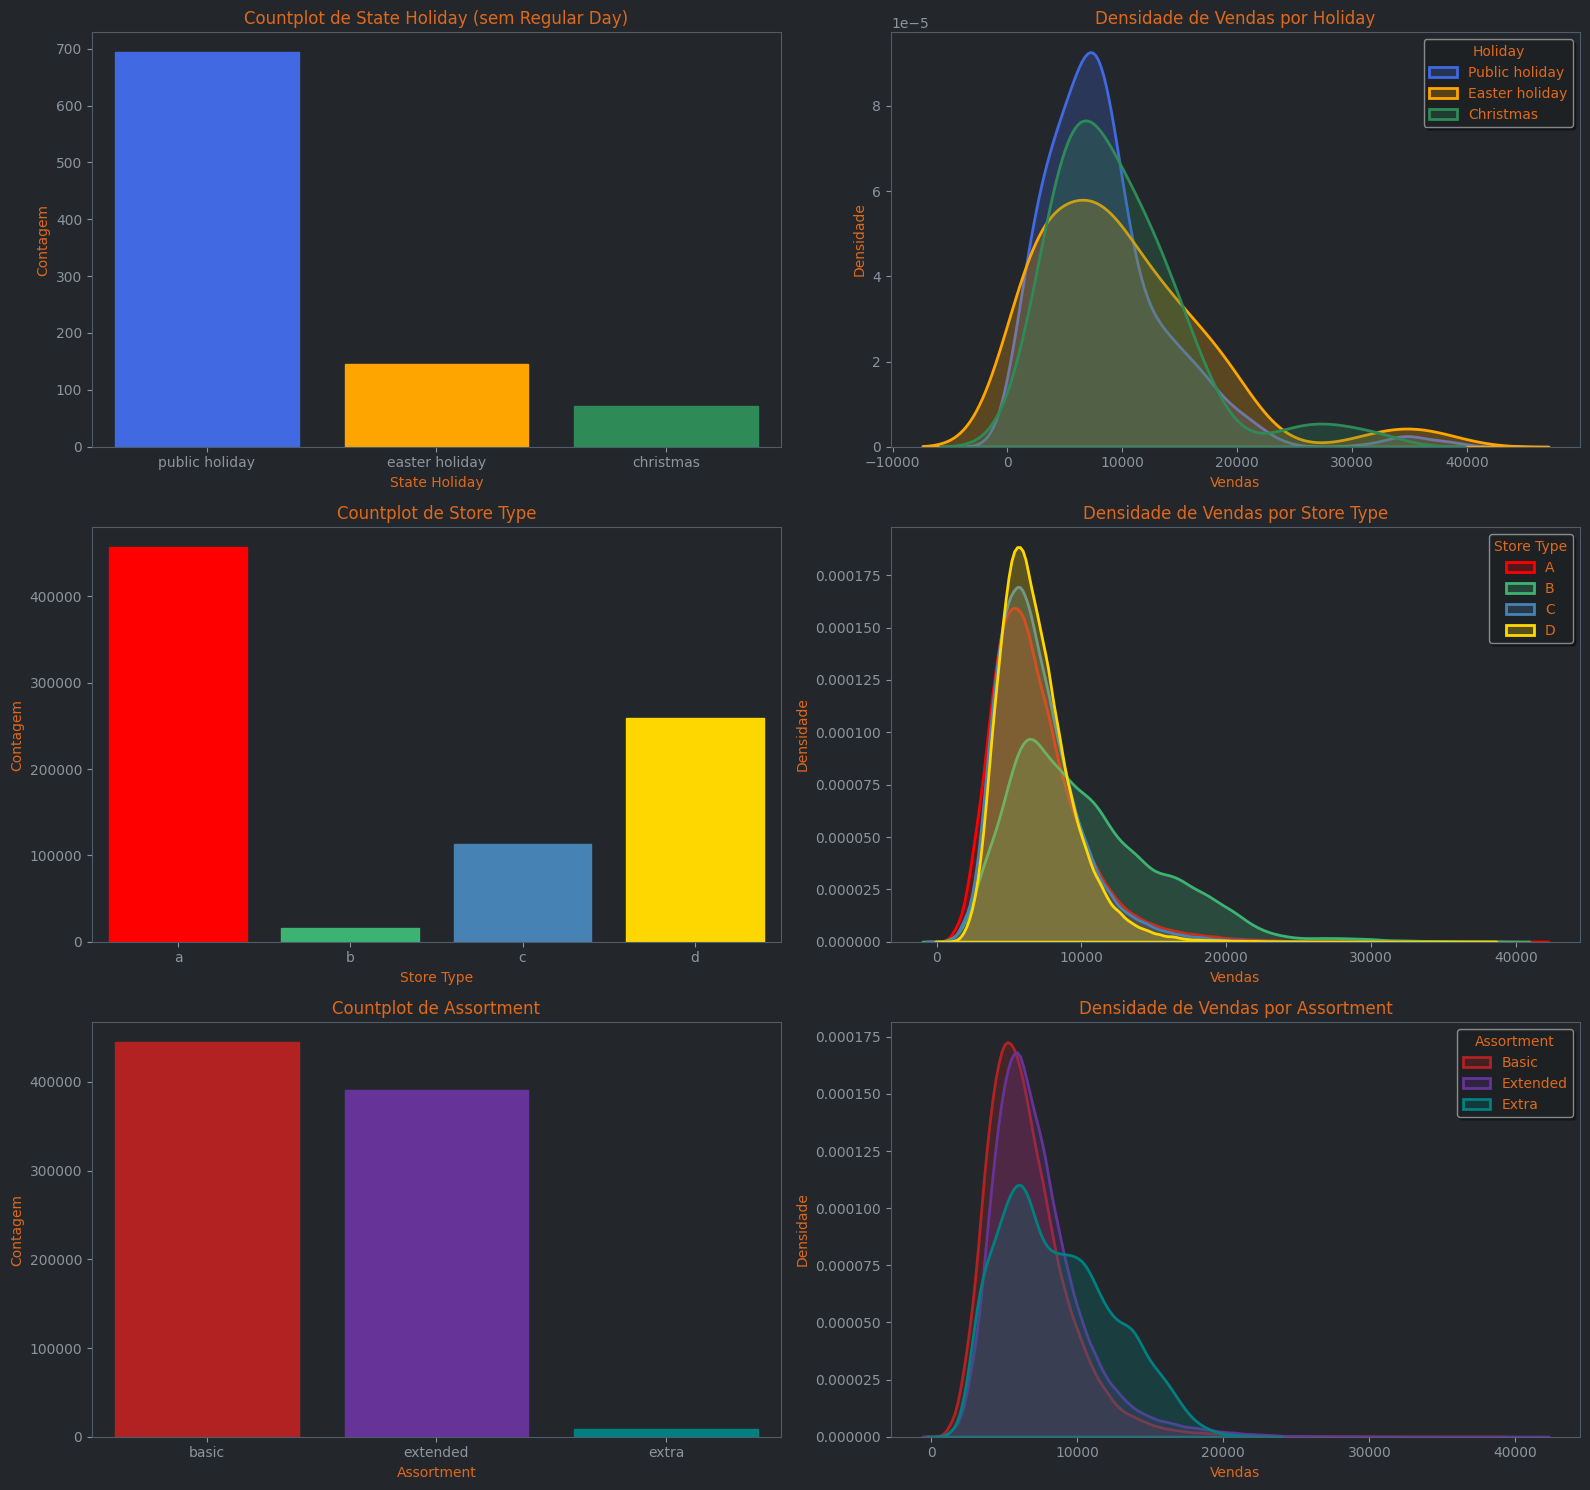

In [26]:

fig, axs = plt.subplots(3, 2, figsize=(16, 15))

# --- State Holiday ---
state_holiday_colors = ['royalblue', 'orange', 'seagreen']
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(
    x='state_holiday', 
    data=a, 
    ax=axs[0,0], 
    color=None 
)
for i, bar in enumerate(axs[0,0].patches):
    if i < len(state_holiday_colors):
        bar.set_color(state_holiday_colors[i])
axs[0,0].set_title('Countplot de State Holiday (sem Regular Day)')
axs[0,0].set_xlabel('State Holiday')
axs[0,0].set_ylabel('Contagem')
holidays = ['public holiday', 'easter holiday', 'christmas']
for idx, holiday in enumerate(holidays):
    subset = df4[df4['state_holiday'] == holiday]
    if not subset.empty:
        sns.kdeplot(
            subset['sales'],
            label=holiday.replace('_', ' ').capitalize(),
            ax=axs[0,1],
            fill=True,
            linewidth=2,
            color=state_holiday_colors[idx]
        )
axs[0,1].set_title('Densidade de Vendas por Holiday')
axs[0,1].set_xlabel('Vendas')
axs[0,1].set_ylabel('Densidade')
axs[0,1].legend(title='Holiday')


# --- Store Type ---
store_type_colors = ['red', 'mediumseagreen', 'steelblue', 'gold']
sns.countplot(
    x='store_type', 
    data=df4, 
    order=['a', 'b', 'c', 'd'], 
    ax=axs[1,0], 
    color=None
)
for i, bar in enumerate(axs[1,0].patches):
    if i < len(store_type_colors):
        bar.set_color(store_type_colors[i])
axs[1,0].set_title('Countplot de Store Type')
axs[1,0].set_xlabel('Store Type')
axs[1,0].set_ylabel('Contagem')
store_types = ['a', 'b', 'c', 'd']
for idx, stype in enumerate(store_types):
    subset = df4[df4['store_type'] == stype]
    if not subset.empty:
        sns.kdeplot(
            subset['sales'],
            label=stype.upper(),
            ax=axs[1,1],
            fill=True,
            linewidth=2,
            color=store_type_colors[idx]
        )
axs[1,1].set_title('Densidade de Vendas por Store Type')
axs[1,1].set_xlabel('Vendas')
axs[1,1].set_ylabel('Densidade')
axs[1,1].legend(title='Store Type')

# --- Assortment ---
assortment_colors = ['firebrick', 'rebeccapurple', 'teal']
sns.countplot(
    x='assortment', 
    data=df4, 
    order=['basic', 'extended', 'extra'], 
    ax=axs[2,0], 
    color=None
)
for i, bar in enumerate(axs[2,0].patches):
    if i < len(assortment_colors):
        bar.set_color(assortment_colors[i])
axs[2,0].set_title('Countplot de Assortment')
axs[2,0].set_xlabel('Assortment')
axs[2,0].set_ylabel('Contagem')
assortments = ['basic', 'extended', 'extra']
for idx, kind in enumerate(assortments):
    subset = df4[df4['assortment'] == kind]
    if not subset.empty:
        sns.kdeplot(
            subset['sales'],
            label=kind.capitalize(),
            ax=axs[2,1],
            fill=True,
            linewidth=2,
            color=assortment_colors[idx]
        )
axs[2,1].set_title('Densidade de Vendas por Assortment')
axs[2,1].set_xlabel('Vendas')
axs[2,1].set_ylabel('Densidade')
axs[2,1].legend(title='Assortment')

plt.tight_layout()
plt.show()





State Holyday - Public holidays são comuns e concentram a maior parte das vendas em feriados — podem coincidir com datas como feriados prolongados e compras em massa. Easter holiday tem uma distribuição de vendas mais alta em média, mesmo ocorrendo poucas vezes, isso indica um evento promocional forte. Christmas tem o maior pico de vendas, mas menor frequência, esperado por ser uma data com alto consumo concentrado em poucos dias.

Lojas do: Tipo A: mais comum, padrão, possivelmente lojas maiores ou mais consolidadas. Tipo B: nichada, menor, vendas baixas. Podem ser lojas teste ou rurais. Tipo D: alto pico de vendas, mesmo com frequência média. Podem ser lojas especializadas ou em pontos estratégicos. Tipo C: mediana em volume e distribuição.

Assortment Basic e extended dominam o volume e têm perfis parecidos. Extra é raríssimo e tem vendas bem menores, ou seja, não compensa ou atende nichos específicos com baixo retorno.

## 4.2 Analise Bivariada

### 4.2.1 Validação de Hipóteses

#### H1 Lojas com maior sortimento deveriam vender mais
Falsa, Lojas com maior sortimento vendem menos.

A Variável possui dois comportamentos distintos, portanto, parece interessante para aplicação no modelo.

C:\Users\Patryck\AppData\Local\Temp\ipykernel_5356\267446400.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


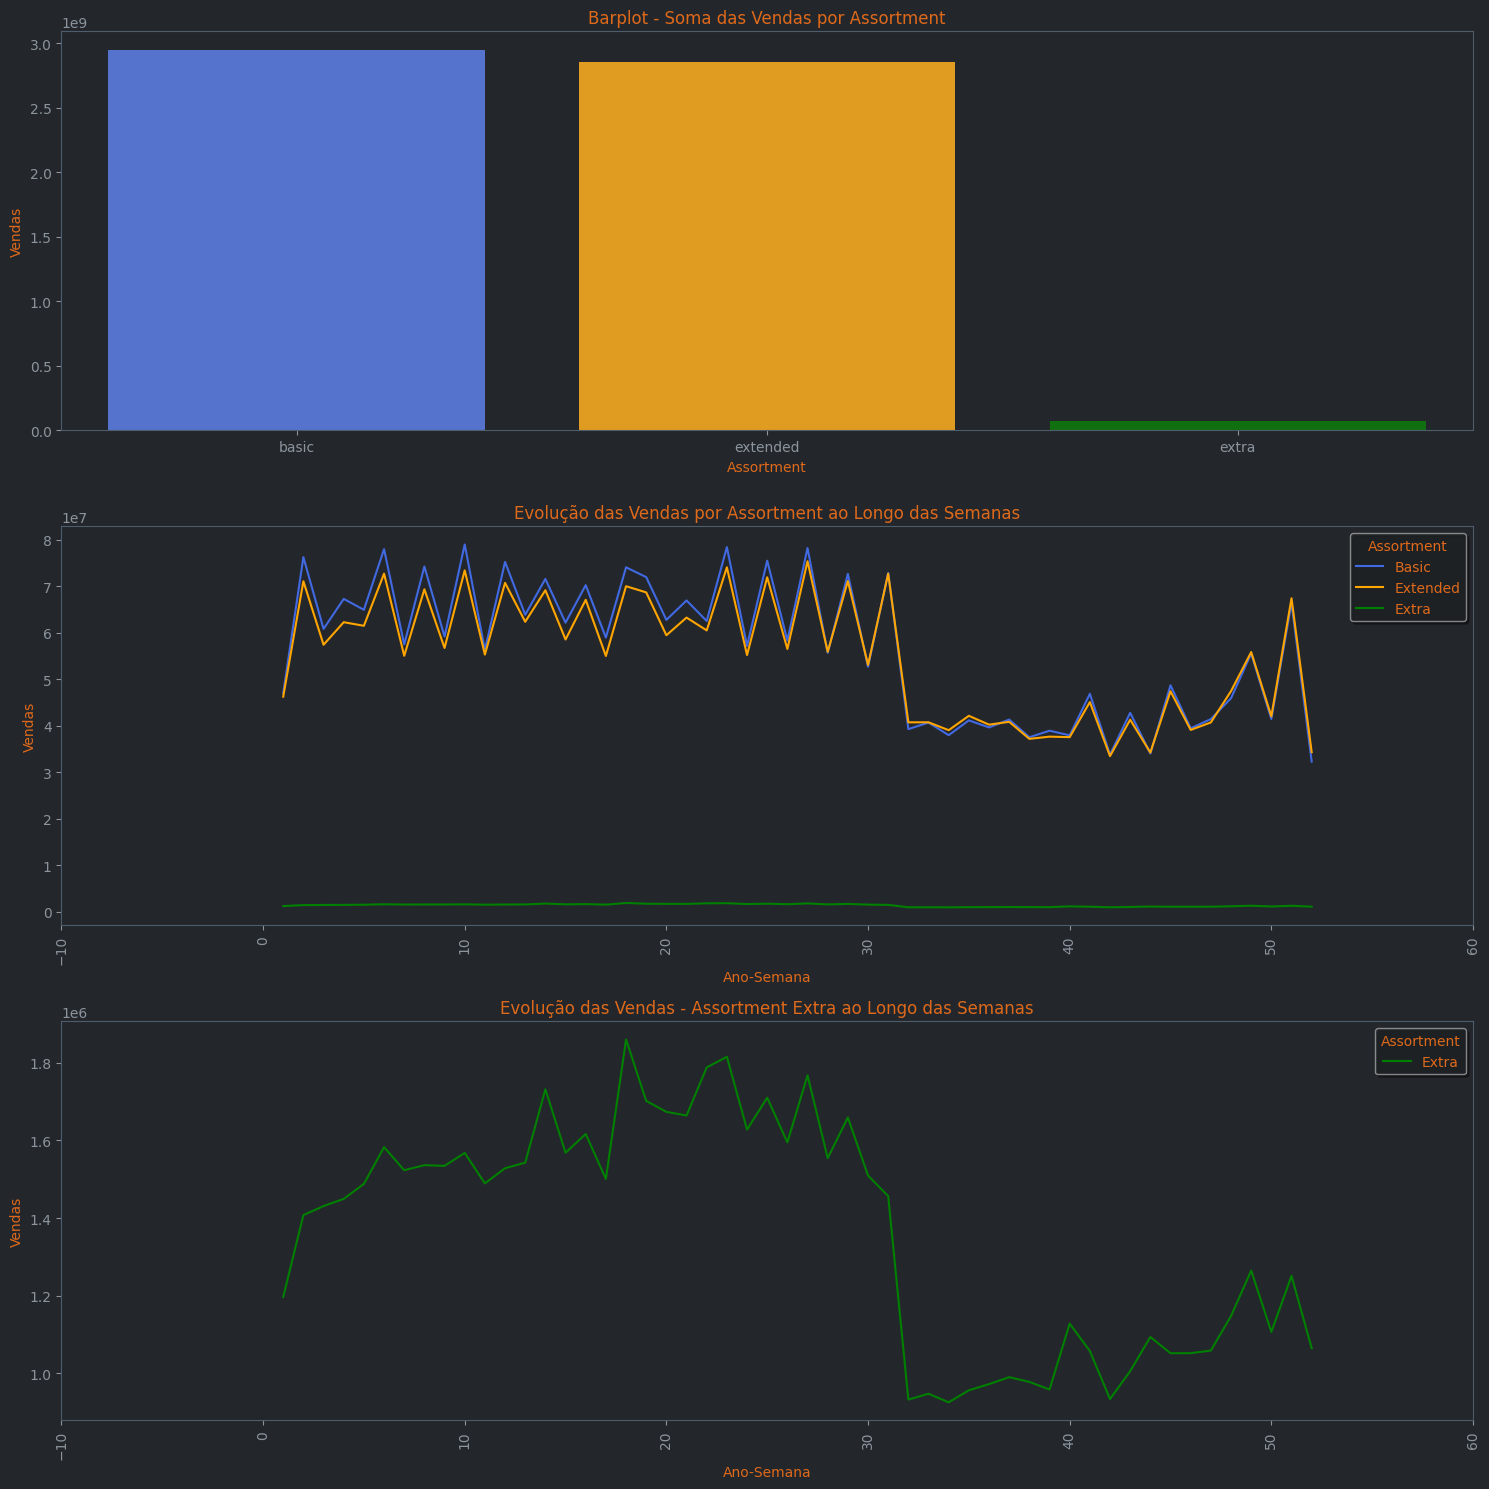

In [27]:
assortment_palette = {'basic': 'royalblue', 'extended': 'orange', 'extra': 'green'}

fig, axs = plt.subplots(3, 1, figsize=(15, 15))


assortment_sales_sum = df4[['assortment', 'sales']].groupby('assortment').sum().reindex(['basic', 'extended', 'extra'])
sns.barplot(
    x=assortment_sales_sum.index, 
    y=assortment_sales_sum['sales'], 
    ax=axs[0], 
    palette=[assortment_palette[a] for a in assortment_sales_sum.index]
)
axs[0].set_title('Barplot - Soma das Vendas por Assortment')
axs[0].set_xlabel('Assortment')
axs[0].set_ylabel('Vendas')
assortment_weeks = df4.groupby(['week_of_year', 'assortment'])['sales'].sum().reset_index()
for assortment in ['basic', 'extended', 'extra']:
    data = assortment_weeks[assortment_weeks['assortment'] == assortment]
    axs[1].plot(
        data['week_of_year'], 
        data['sales'], 
        label=assortment.capitalize(),
        color=assortment_palette[assortment]
    )

axs[1].set_title('Evolução das Vendas por Assortment ao Longo das Semanas')
axs[1].set_xlabel('Ano-Semana')
axs[1].set_ylabel('Vendas')
axs[1].legend(title='Assortment')

xticks_1 = axs[1].get_xticks()
xticklabels_1 = axs[1].get_xticklabels()
step_1 = max(1, len(xticklabels_1)//12)
axs[1].set_xticks(xticks_1[::step_1])
axs[1].set_xticklabels([label.get_text() for label in xticklabels_1][::step_1], rotation=90)

data_extra = assortment_weeks[assortment_weeks['assortment'] == 'extra']
axs[2].plot(
    data_extra['week_of_year'],
    data_extra['sales'],
    color=assortment_palette['extra'],
    label='Extra'
)
axs[2].set_title('Evolução das Vendas - Assortment Extra ao Longo das Semanas')
axs[2].set_xlabel('Ano-Semana')
axs[2].set_ylabel('Vendas')
axs[2].legend(title='Assortment')

xticks_2 = axs[2].get_xticks()
xticklabels_2 = axs[2].get_xticklabels()
step_2 = max(1, len(xticklabels_2)//12)
axs[2].set_xticks(xticks_2[::step_2])
axs[2].set_xticklabels([label.get_text() for label in xticklabels_2][::step_2], rotation=90)

plt.tight_layout()
plt.show()


#### H2 Lojas com competidores mais próximos deveriam vender menos.
Falsa, Lojas com competidores mais próximos vendem mais.

A variável possui um valor estatístico meidiano/baixo e um comportamento em comum, assim, parece útil para aplicação no modelo.

C:\Users\Patryck\AppData\Local\Temp\ipykernel_5356\1486982101.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Patryck\AppData\Local\Temp\ipykernel_5356\1486982101.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


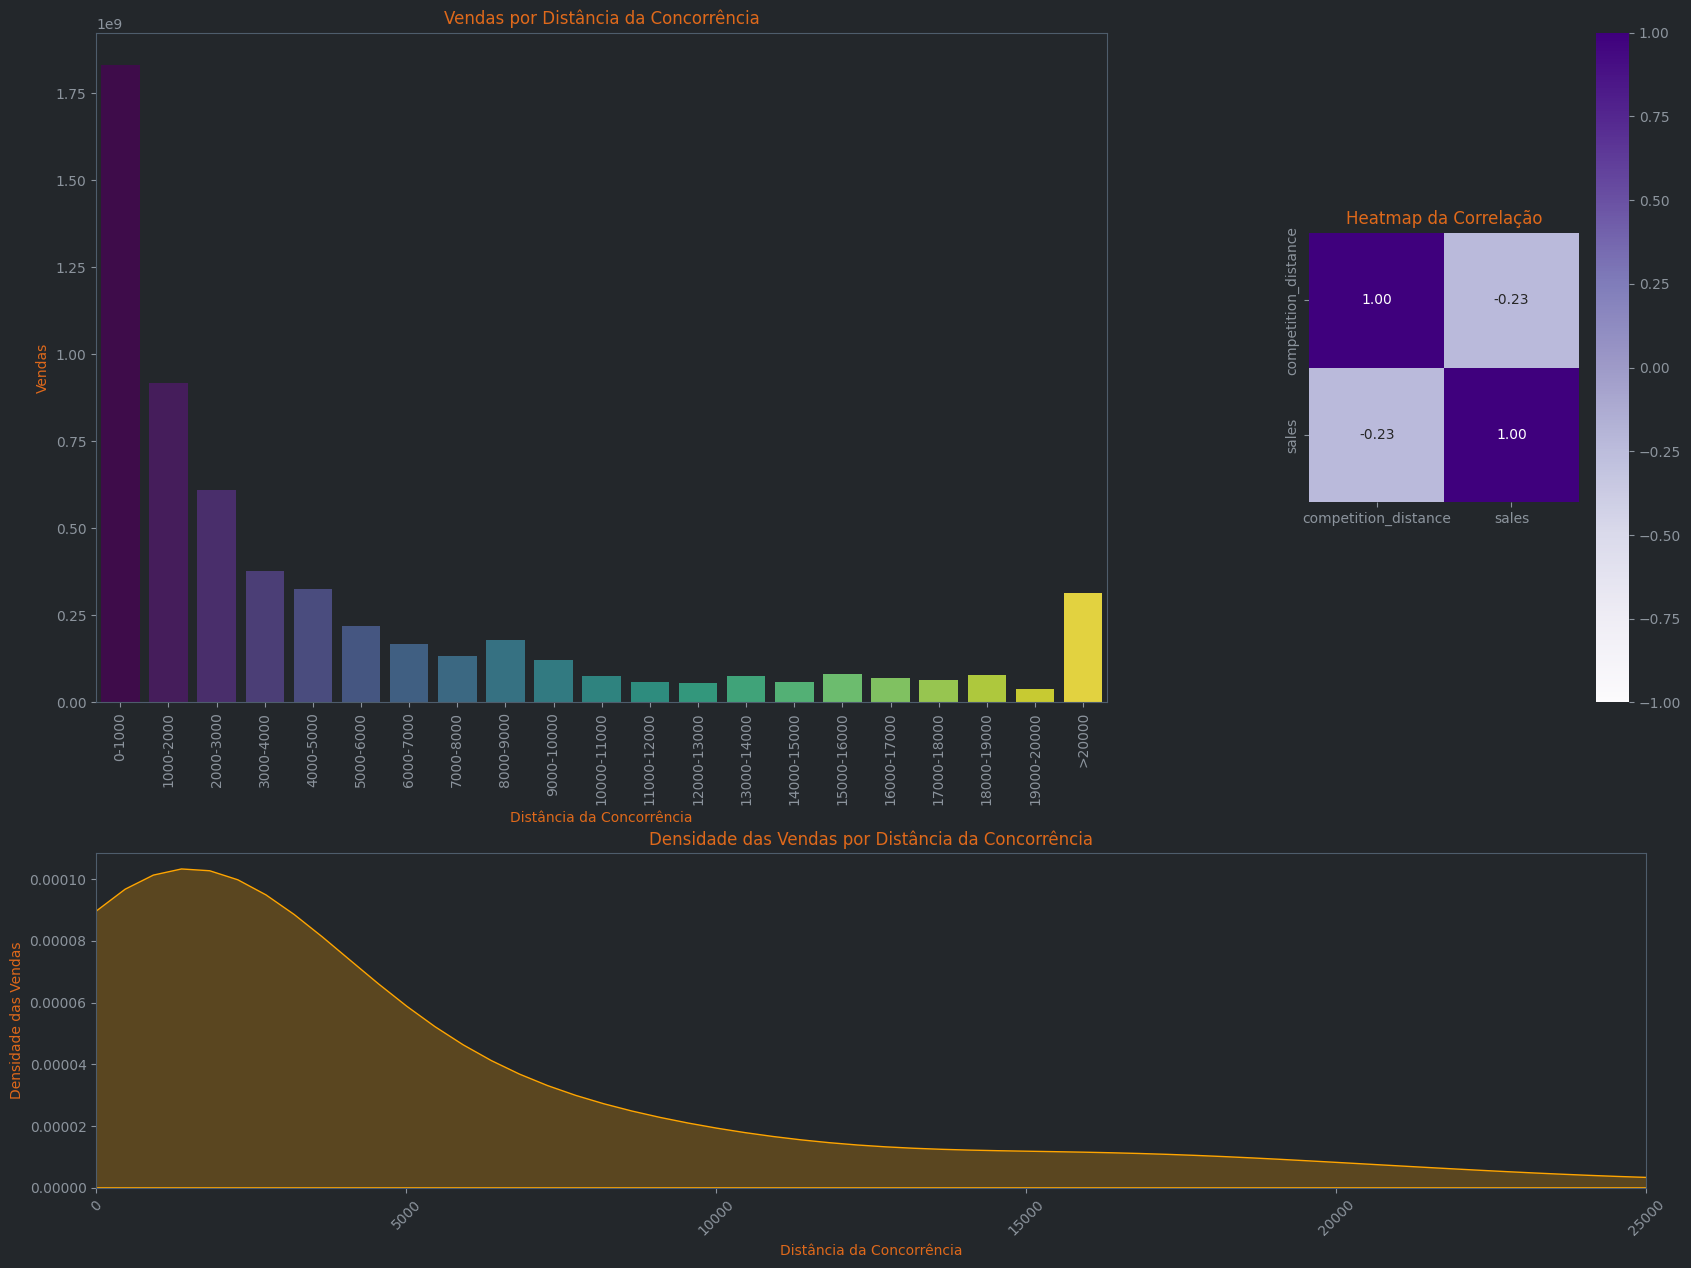

In [28]:

aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
aux2 = aux1[aux1['competition_distance'] != 200000.0].copy()


bin_edges = np.arange(0, 21000, 1000)
bin_edges = np.append(bin_edges, np.inf) 

labels = [f'{i}-{i+1000}' for i in range(0,20000,1000)] + ['>20000']

aux2['competition_distance_bin'] = pd.cut(
    aux2['competition_distance'],
    bins=bin_edges, 
    labels=labels,
    include_lowest=True
)

sales_by_distance = (
    aux2
    .groupby('competition_distance_bin', observed=False)['sales']
    .sum()
    .reindex(labels)
)


sales_by_distance_line = (
    aux2.groupby('competition_distance')['sales'].sum().sort_index()
)


num_bins = len(labels)
colors = plt.colormaps['viridis'](np.linspace(0, 1, num_bins))
colors = colors.tolist()


corr_matrix = aux1.corr(method='pearson')

fig = plt.figure(figsize=(20, 15))
grid = plt.GridSpec(2, 2, height_ratios=[2, 1], width_ratios=[3, 1], hspace=0.3, wspace=0.3)

ax0 = fig.add_subplot(grid[0, 0])
sns.barplot(
    x=sales_by_distance.index,
    y=sales_by_distance.values,
    ax=ax0,
    palette=colors,
    legend=False
)
ax0.set_title('Vendas por Distância da Concorrência')
ax0.set_xlabel('Distância da Concorrência')
ax0.set_ylabel('Vendas')
ax0.tick_params(axis='x', rotation=90)

axh = fig.add_subplot(grid[0, 1])
sns.heatmap(
    corr_matrix,
    annot=True, 
    fmt='.2f', 
    cmap='Purples', 
    vmin=-1, vmax=1, 
    square=True, 
    cbar=True, 
    ax=axh
)
axh.set_title('Heatmap da Correlação')

ax1 = fig.add_subplot(grid[1, :])
sns.kdeplot(
    data=aux2,
    x='competition_distance',
    weights='sales',
    fill=True,
    ax=ax1,
    color='orange'
)
ax1.set_title('Densidade das Vendas por Distância da Concorrência')
ax1.set_xlabel('Distância da Concorrência')
ax1.set_ylabel('Densidade das Vendas')
ax1.set_xlim(left=0, right=min(25000, aux2['competition_distance'].max()))
ax1.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



#### H3 Lojas com competidores a mais tempo deveriam vender mais.
Falsa, lojas com competidores a mais tempo vendem menos.

A variável tem um valor estatístico baixo, mas parece ter um certo comportamento, suficiente para ser aplicada ao modelo.

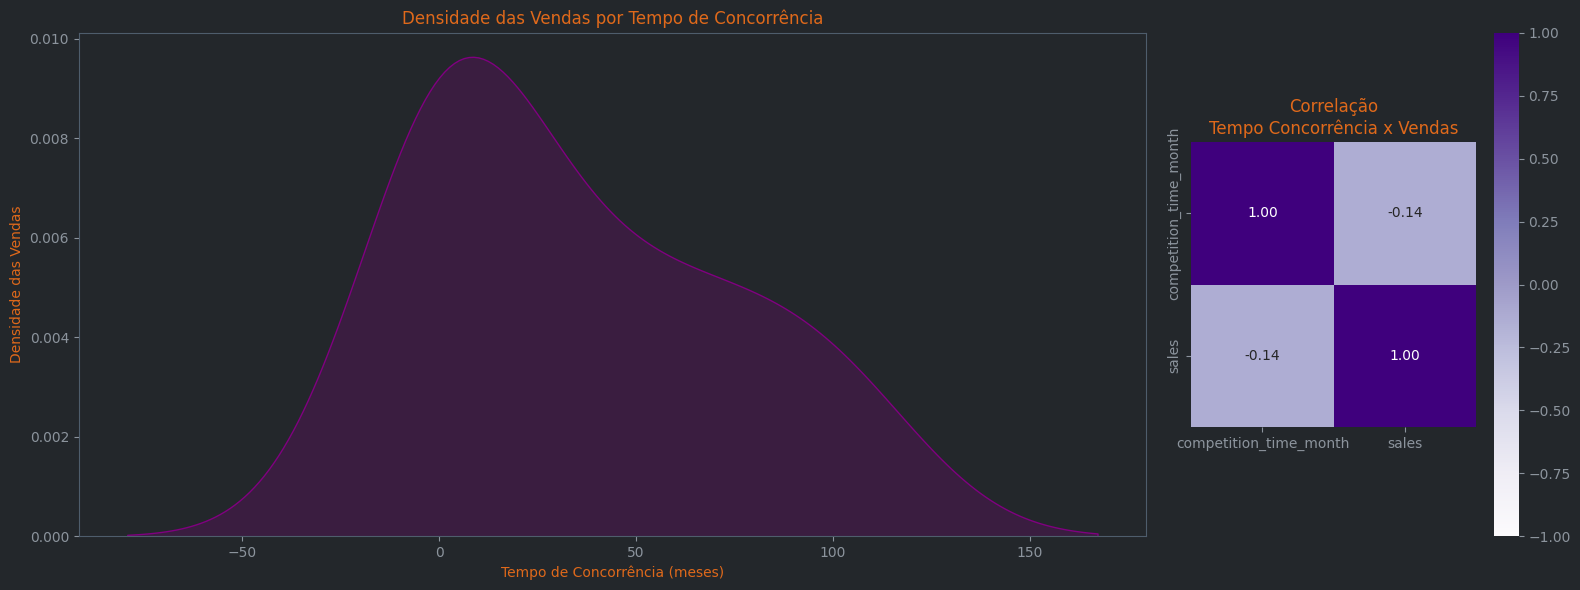

In [29]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] != 0) & (aux1['competition_time_month'] < 120)]

fig, (ax_kde, ax_hm) = plt.subplots(1, 2, figsize=(16,6), gridspec_kw={'width_ratios': [3, 1]})

sns.kdeplot(
    data=aux2,
    x='competition_time_month',
    weights='sales',
    fill=True,
    color='purple',
    ax=ax_kde
)
ax_kde.set_title('Densidade das Vendas por Tempo de Concorrência')
ax_kde.set_xlabel('Tempo de Concorrência (meses)')
ax_kde.set_ylabel('Densidade das Vendas')

heatmap_data = aux1.corr(method='pearson')


sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.2f',
    cmap='Purples',
    vmin=-1, vmax=1,
    square=True,
    cbar=True,
    ax=ax_hm
)
ax_hm.set_title('Correlação\nTempo Concorrência x Vendas')

plt.tight_layout()
plt.show()





#### H4 Lojas com promoções ativas por mais tempo deveriam vender mais.
Falsa, lojas com promoções ativas por mais tempo vendem menos, e vendem mais quando estão próximos de iniciar a promoção.

A variável parece ter um valor estatístico alto, no entando, isso é causado na exclusão do 0 no calculo e divisão dos valores, portanto, pode não ser útil a primeira vista, mas vale a tentativa de criar uma nova variável a partir dela. Ex: promo_passed, onde 0 é valores positivos e 0, e 1 são valores negativos.

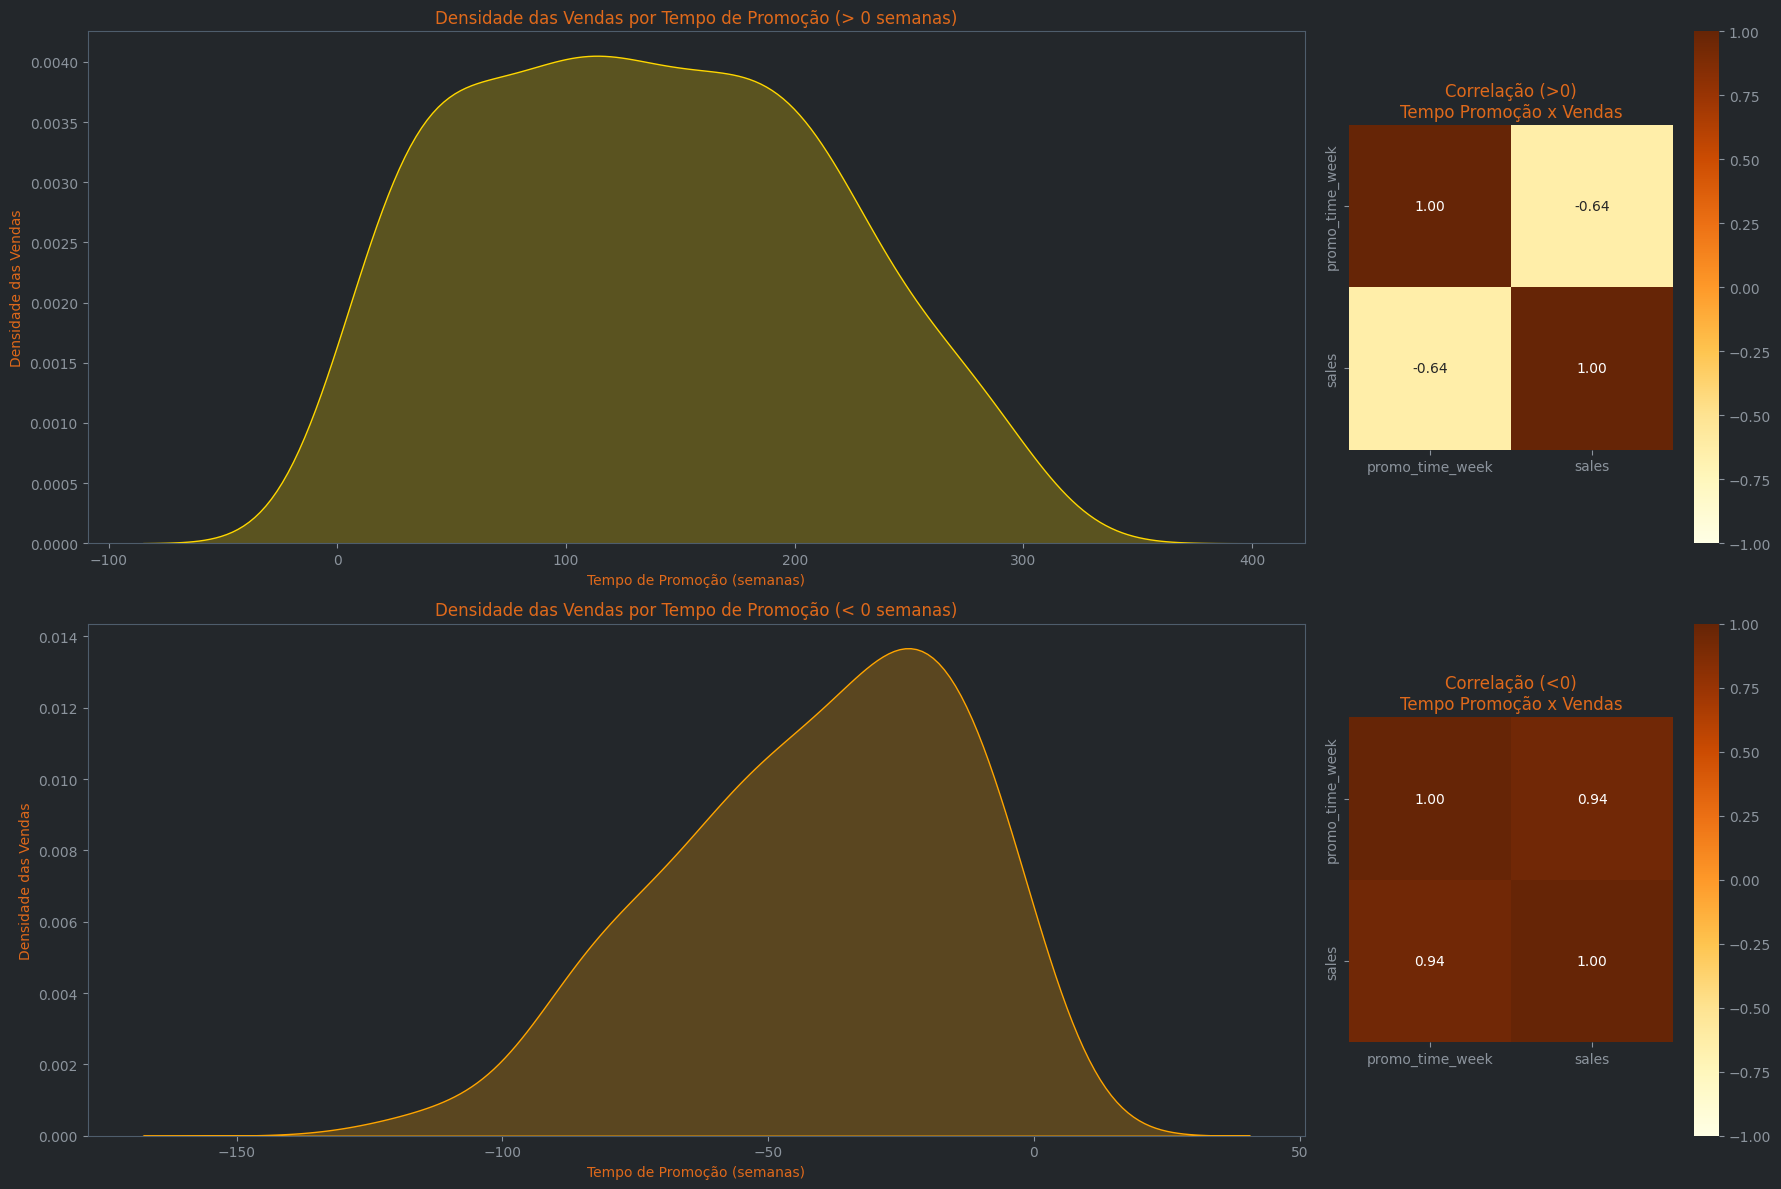

In [30]:
aux_pos = df4[df4['promo_time_week'] > 0][['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
aux_neg = df4[df4['promo_time_week'] < 0][['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

fig, axs = plt.subplots(2, 2, figsize=(18, 12), gridspec_kw={'width_ratios': [3, 1], 'height_ratios': [1, 1]})

sns.kdeplot(
    data=aux_pos,
    x='promo_time_week',
    weights='sales',
    fill=True,
    color='gold',
    ax=axs[0, 0]
)
axs[0, 0].set_title('Densidade das Vendas por Tempo de Promoção (> 0 semanas)')
axs[0, 0].set_xlabel('Tempo de Promoção (semanas)')
axs[0, 0].set_ylabel('Densidade das Vendas')

heatmap_data_pos = aux_pos.corr(method='pearson')
sns.heatmap(
    heatmap_data_pos,
    annot=True,
    fmt='.2f',
    cmap='YlOrBr',
    vmin=-1, vmax=1,
    square=True,
    cbar=True,
    ax=axs[0, 1]
)
axs[0, 1].set_title('Correlação (>0)\nTempo Promoção x Vendas')

sns.kdeplot(
    data=aux_neg,
    x='promo_time_week',
    weights='sales',
    fill=True,
    color='orange',
    ax=axs[1, 0]
)
axs[1, 0].set_title('Densidade das Vendas por Tempo de Promoção (< 0 semanas)')
axs[1, 0].set_xlabel('Tempo de Promoção (semanas)')
axs[1, 0].set_ylabel('Densidade das Vendas')

heatmap_data_neg = aux_neg.corr(method='pearson')
sns.heatmap(
    heatmap_data_neg,
    annot=True,
    fmt='.2f',
    cmap='YlOrBr',
    vmin=-1, vmax=1,
    square=True,
    cbar=True,
    ax=axs[1, 1]
)
axs[1, 1].set_title('Correlação (<0)\nTempo Promoção x Vendas')

plt.tight_layout()
plt.show()


In [31]:
df4['promo_passed'] = df4['promo_time_week'].apply(lambda x: 0 if x >= 0 else 1)

#### <s>H5 Lojas com mais dias de promoção deveriam vender mais.</s>

#### H6 Lojas com promoção consecutiva vendem mais.
Falsa, lojas que participaram da segunda promoção não vendem mais, no geral, participar da primeira promoção que parece ser mais importante para as vendas, mas promoção não parece ser tão importante para as vendas.

A variável não apresenta um comportamento tão diferente para cada um dos valores, portanto, a primeira vista não parece ser útil para o modelo, mas pode ser útil em uma análise multivariada.

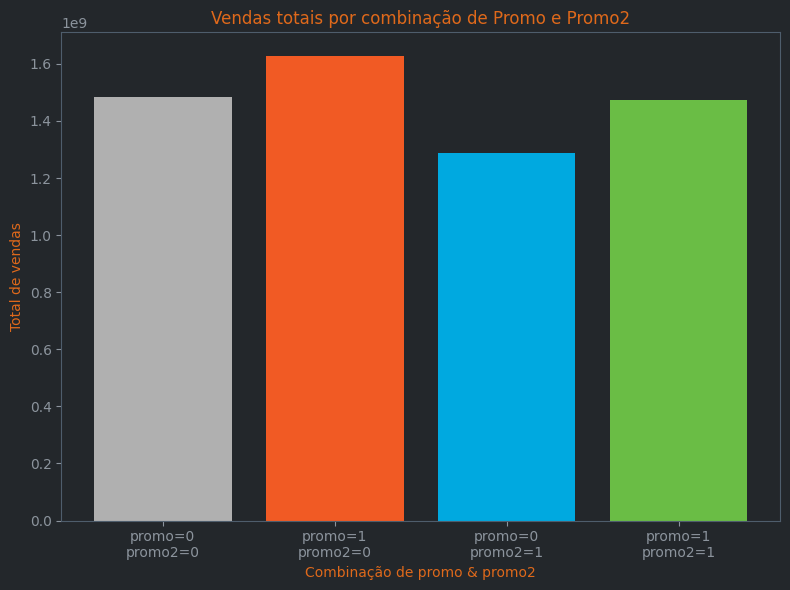

In [32]:
aux1 = df4[['promo2', 'promo', 'sales']].groupby(['promo2', 'promo']).sum().reset_index()

order = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1)
]
order_labels = ['promo=0\npromo2=0','promo=1\npromo2=0','promo=0\npromo2=1','promo=1\npromo2=1']
all_combinations = pd.DataFrame(order, columns=['promo2', 'promo'])
aux1 = pd.merge(all_combinations, aux1, on=['promo2', 'promo'], how='left')
aux1['sales'] = aux1['sales'].fillna(0)
plt.figure(figsize=(8, 6))
bars = plt.bar(order_labels, aux1['sales'], color=['#b0b0b0', '#f15a24', '#00a9e0', '#6abd45'])
plt.xlabel('Combinação de promo & promo2')
plt.ylabel('Total de vendas')
plt.title('Vendas totais por combinação de Promo e Promo2')
plt.tight_layout()
plt.show()

#### H7 Lojas abertas durante o feriado de natal deveriam vender mais.
Falsa, Lojas abertas durante o feriado de natal vendem menos.

A variável possui um comportamento claro, então, provavelmetne será útil para o modelo.

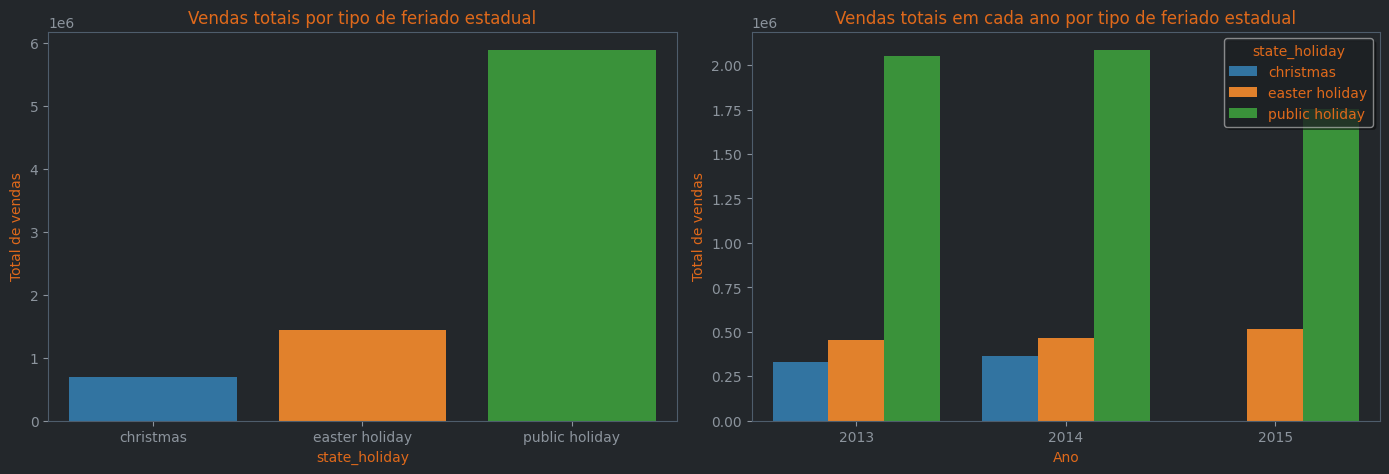

In [33]:
aux1 = df4[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
aux1 = aux1[aux1['state_holiday'] != 'regular_day']

aux2 = df4[df4['state_holiday'] != 'regular_day'][['year', 'state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=aux1, x='state_holiday', y='sales', hue='state_holiday', dodge=False, legend=False, ax=axes[0])
axes[0].set_xlabel('state_holiday')
axes[0].set_ylabel('Total de vendas')
axes[0].set_title('Vendas totais por tipo de feriado estadual')

sns.barplot(data=aux2, x='year', y='sales', hue='state_holiday', ax=axes[1])
axes[1].set_xlabel('Ano')
axes[1].set_ylabel('Total de vendas')
axes[1].set_title('Vendas totais em cada ano por tipo de feriado estadual')

plt.tight_layout()
plt.show()

#### H8 Lojas deveriam vender mais ao longo dos anos.
Falsa, lojas vendem menos ao longo dos anos.

A variável possui um valor estatístico muito alto, além de um comportamento claro, então será extremamente útil para o modelo

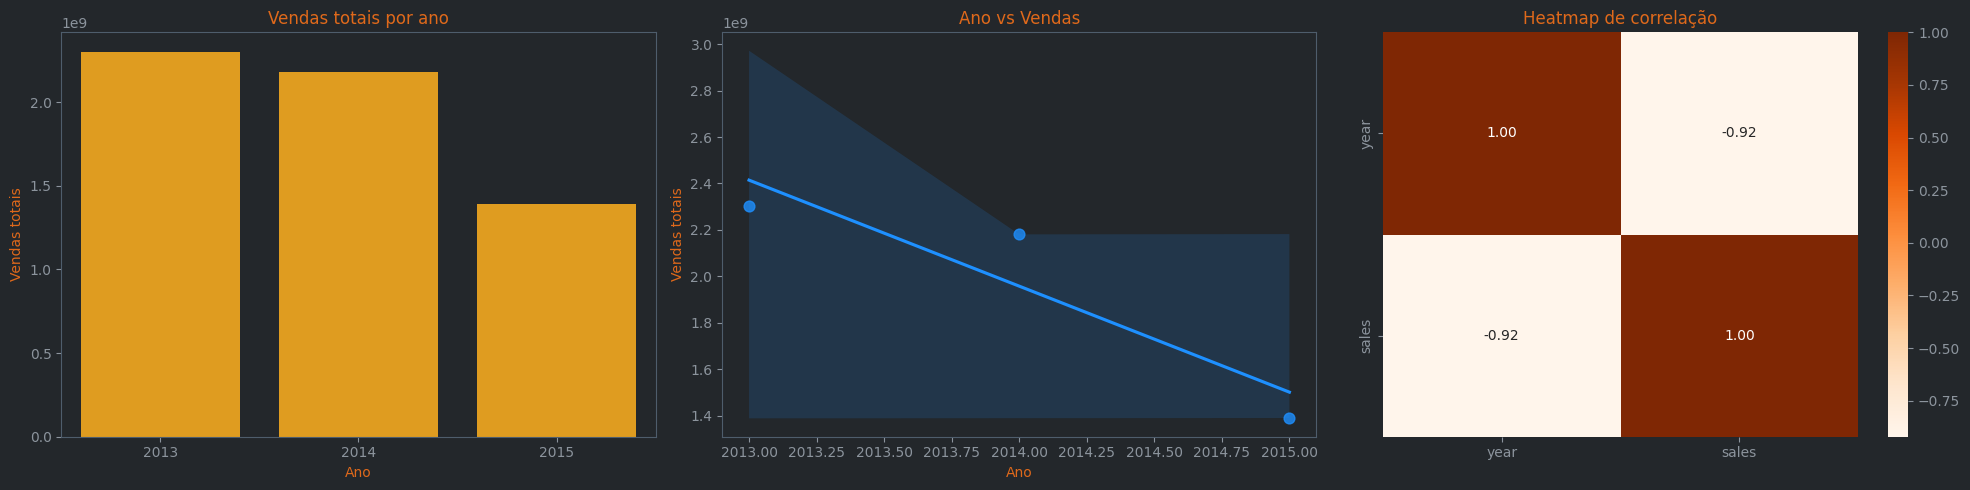

In [34]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.barplot(data=aux1, x='year', y='sales', color='orange', ax=axes[0])
axes[0].set_xlabel('Ano')
axes[0].set_ylabel('Vendas totais')
axes[0].set_title('Vendas totais por ano')

sns.regplot(data=aux1, x='year', y='sales', ax=axes[1], color='dodgerblue', scatter_kws={'s': 60})
axes[1].set_xlabel('Ano')
axes[1].set_ylabel('Vendas totais')
axes[1].set_title('Ano vs Vendas')

corr_matrix = aux1.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='Oranges', ax=axes[2])
axes[2].set_title('Heatmap de correlação')

plt.tight_layout()
plt.show()

#### H9 Lojas deveriam vender mais no segundo semestre do ano.
Falsa, lojas vendem menos no segundo semestre do ano.

A variável tem um comportamento claro e um valor estatístico alto, portanto, será extremamente útil para o modelo.

C:\Users\Patryck\AppData\Local\Temp\ipykernel_5356\212669736.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


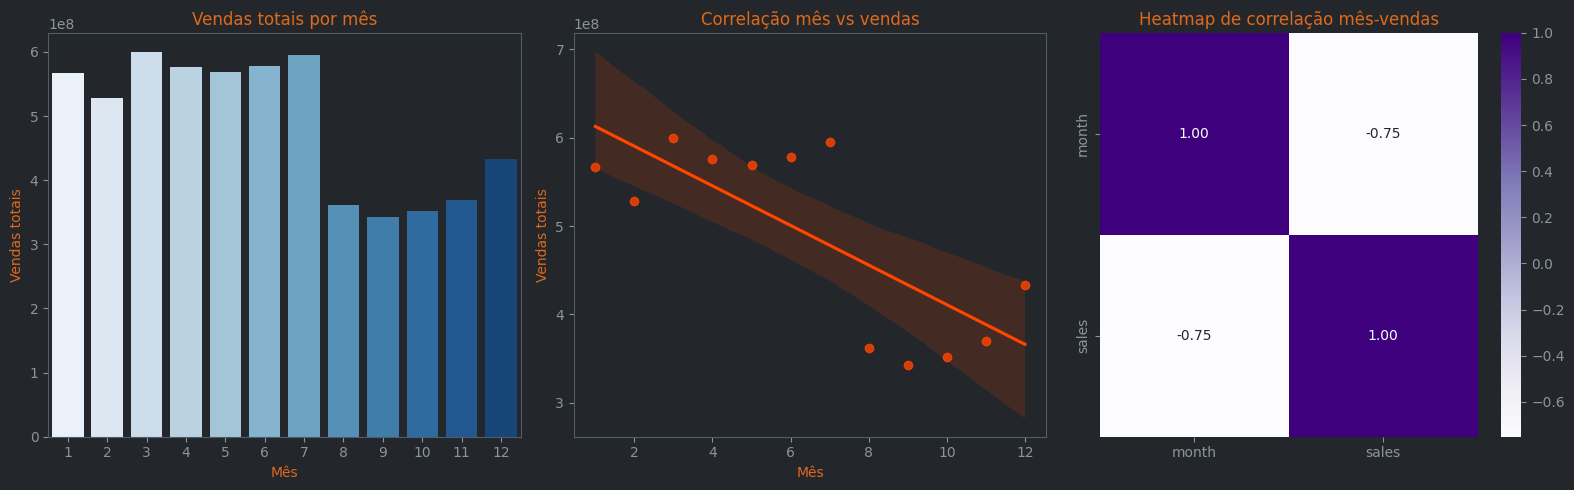

In [35]:
month_sales = df4.groupby('month')['sales'].sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

sns.barplot(
    data=month_sales,
    x='month',
    y='sales',
    palette='Blues',
    ax=axes[0]
)
axes[0].set_xlabel('Mês')
axes[0].set_ylabel('Vendas totais')
axes[0].set_title('Vendas totais por mês')

sns.regplot(
    data=month_sales,
    x='month',
    y='sales',
    ax=axes[1],
    color='orangered'
)
axes[1].set_xlabel('Mês')
axes[1].set_ylabel('Vendas totais')
axes[1].set_title('Correlação mês vs vendas')

corr_matrix = month_sales.corr()
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='Purples',
    ax=axes[2]
)
axes[2].set_title('Heatmap de correlação mês-vendas')

plt.tight_layout()
plt.show()


#### H10 Lojas deveriam vender mais depois do dia 10.
Falsa, as lojas vendem mais antes ou logo após o dia 10, e menos no fim do mês.

Há um certo comportamento e um valor estatístico médio, portanto, parece interessante para o modelo.

C:\Users\Patryck\AppData\Local\Temp\ipykernel_5356\207446995.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=aux1, x='day', y='sales', palette='Blues', ax=axes[0])


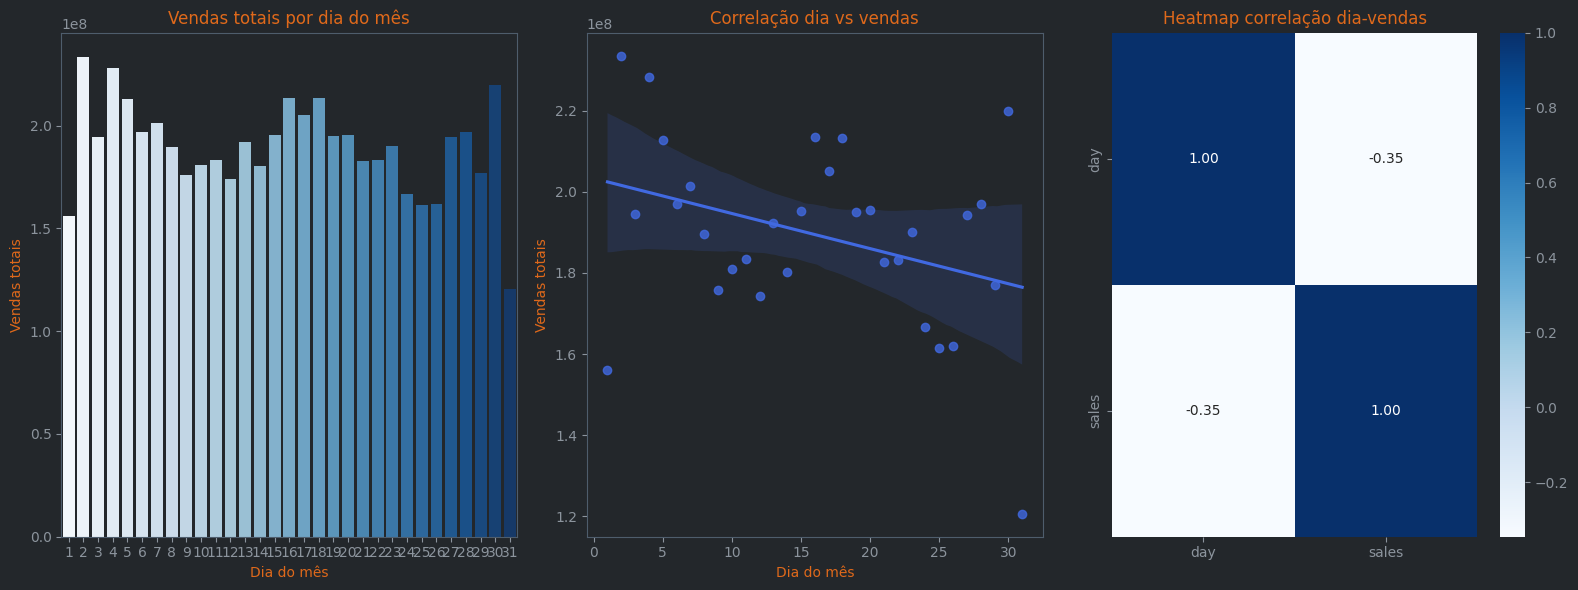

In [36]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(16, 6))

sns.barplot(data=aux1, x='day', y='sales', palette='Blues', ax=axes[0])
axes[0].set_xlabel('Dia do mês')
axes[0].set_ylabel('Vendas totais')
axes[0].set_title('Vendas totais por dia do mês')

sns.regplot(data=aux1, x='day', y='sales', color='royalblue', ax=axes[1])
axes[1].set_xlabel('Dia do mês')
axes[1].set_ylabel('Vendas totais')
axes[1].set_title('Correlação dia vs vendas')

corr_matrix_day = aux1[['day', 'sales']].corr()
sns.heatmap(corr_matrix_day, annot=True, fmt=".2f", cmap='Blues', ax=axes[2])
axes[2].set_title('Heatmap correlação dia-vendas')

plt.tight_layout()
plt.show()


#### H11 Lojas vendem menos no final de semana.
Verdadeira, lojas vendem menos no final de semana e conforme se aproximam dele.

Há um comportamento claro e um valor estatístico alto, portanto, a variável será útil para o modelo.

C:\Users\Patryck\AppData\Local\Temp\ipykernel_5356\3171359343.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=aux1, x='day_of_week', y='sales', palette='Blues', ax=axes[0])


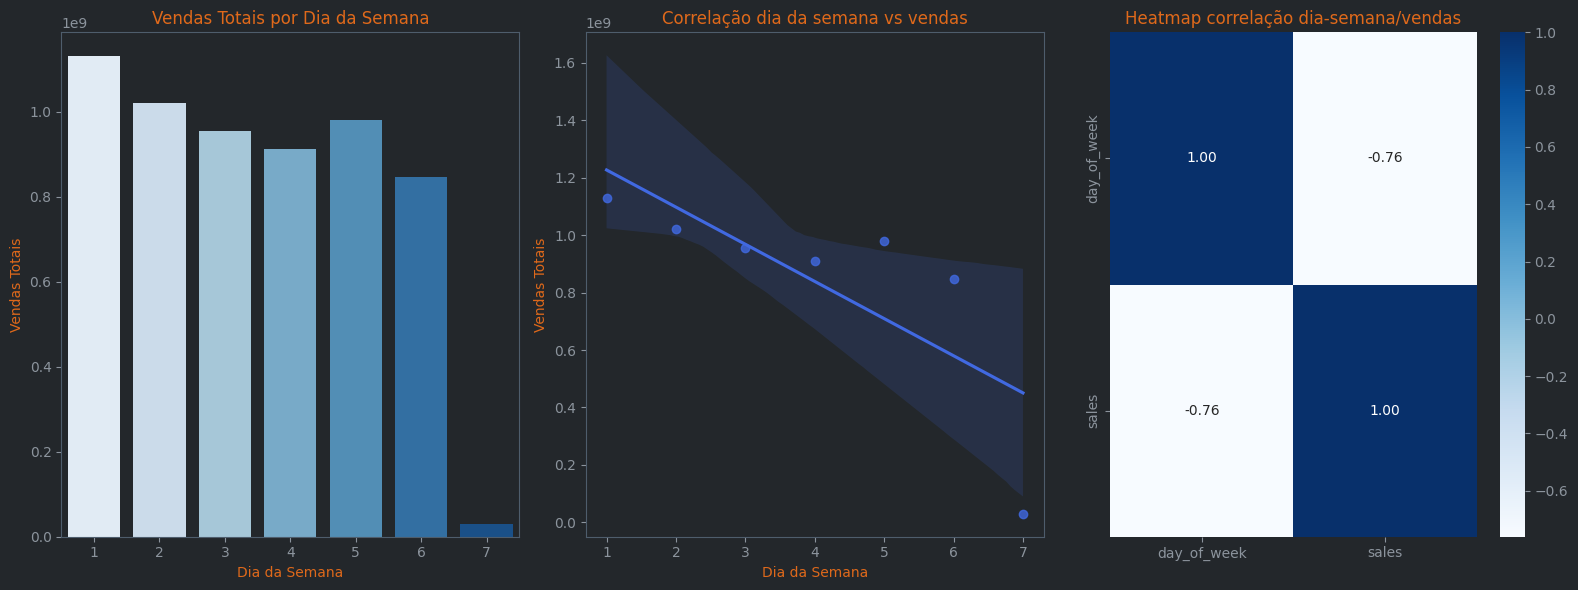

In [37]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(16, 6))

sns.barplot(data=aux1, x='day_of_week', y='sales', palette='Blues', ax=axes[0])
axes[0].set_xlabel('Dia da Semana')
axes[0].set_ylabel('Vendas Totais')
axes[0].set_title('Vendas Totais por Dia da Semana')

sns.regplot(data=aux1, x='day_of_week', y='sales', color='royalblue', ax=axes[1])
axes[1].set_xlabel('Dia da Semana')
axes[1].set_ylabel('Vendas Totais')
axes[1].set_title('Correlação dia da semana vs vendas')

corr_matrix_dow = aux1[['day_of_week', 'sales']].corr()
sns.heatmap(corr_matrix_dow, annot=True, fmt=".2f", cmap='Blues', ax=axes[2])
axes[2].set_title('Heatmap correlação dia-semana/vendas')

plt.tight_layout()
plt.show()


#### H12 Lojas deveriam vender menos durante feriados escolares.
True, lojas vendem menos durante feriados escolares, mas no mês 7 e 8  (Provável Férias), as vendas se equiparam.

Apesar de muito discrepante as diferenças, há um comportamento, portanto, pode ser que seja útil para o modelo.

C:\Users\Patryck\AppData\Local\Temp\ipykernel_5356\2545498109.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=aux1, x='school_holiday', y='sales', palette='Blues', ax=axes[0])


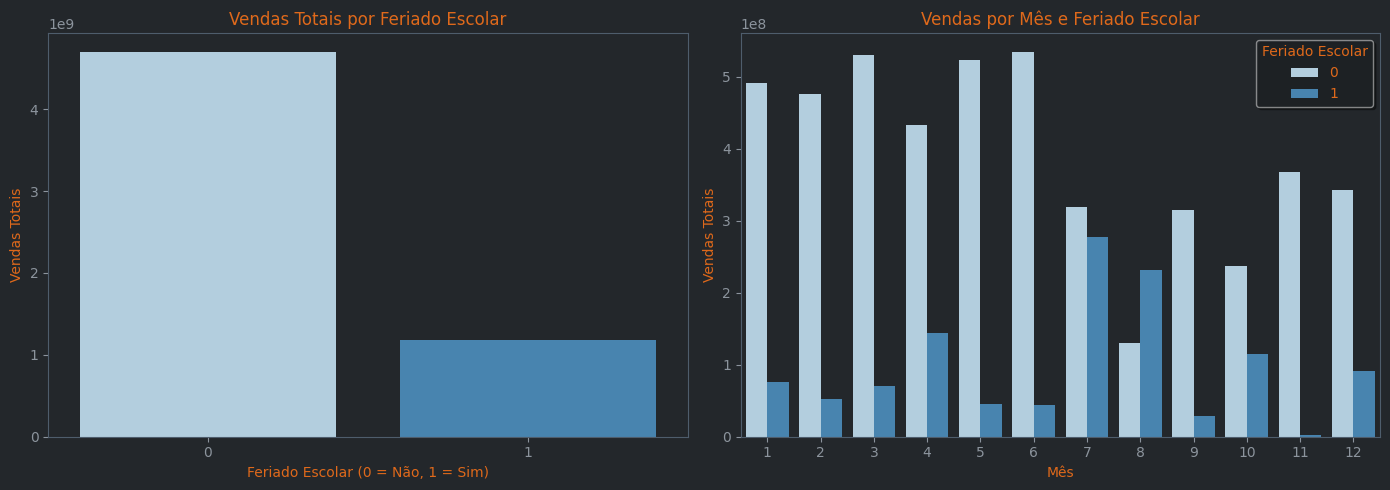

In [38]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
aux2 = df4[['school_holiday', 'month', 'sales']].groupby(['school_holiday', 'month']).sum().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(14,5))

sns.barplot(data=aux1, x='school_holiday', y='sales', palette='Blues', ax=axes[0])
axes[0].set_xlabel('Feriado Escolar (0 = Não, 1 = Sim)')
axes[0].set_ylabel('Vendas Totais')
axes[0].set_title('Vendas Totais por Feriado Escolar')

sns.barplot(data=aux2, x='month', y='sales', hue='school_holiday', palette='Blues', ax=axes[1])
axes[1].set_xlabel('Mês')
axes[1].set_ylabel('Vendas Totais')
axes[1].set_title('Vendas por Mês e Feriado Escolar')
axes[1].legend(title='Feriado Escolar', loc='best')

plt.tight_layout()
plt.show()



### 4.2.2 Conclusão Hipóteses

| Hipóteses | Conclusão   | Relevância |
|------------|-------------|-------------|
| H1         | Falsa       | Baixa       |
| H2         | Falsa       | Média       |
| H3         | Falsa       | Média       |
| H4         | Falsa       | Baixa       |
| H5         | -           | -           |
| H6         | Falsa       | Baixa       |
| H7         | Falsa       | Média       |
| H8         | Falsa       | Alta        |
| H9         | Falsa       | Alta        |
| H10        | Verdadeira  | Alta        |
| H11        | Verdadeira  | Alta        |
| H12        | Verdadeira  | Baixa       |


## 4.3 Analise Multivariada

### 4.3.1 Numerical Attributes

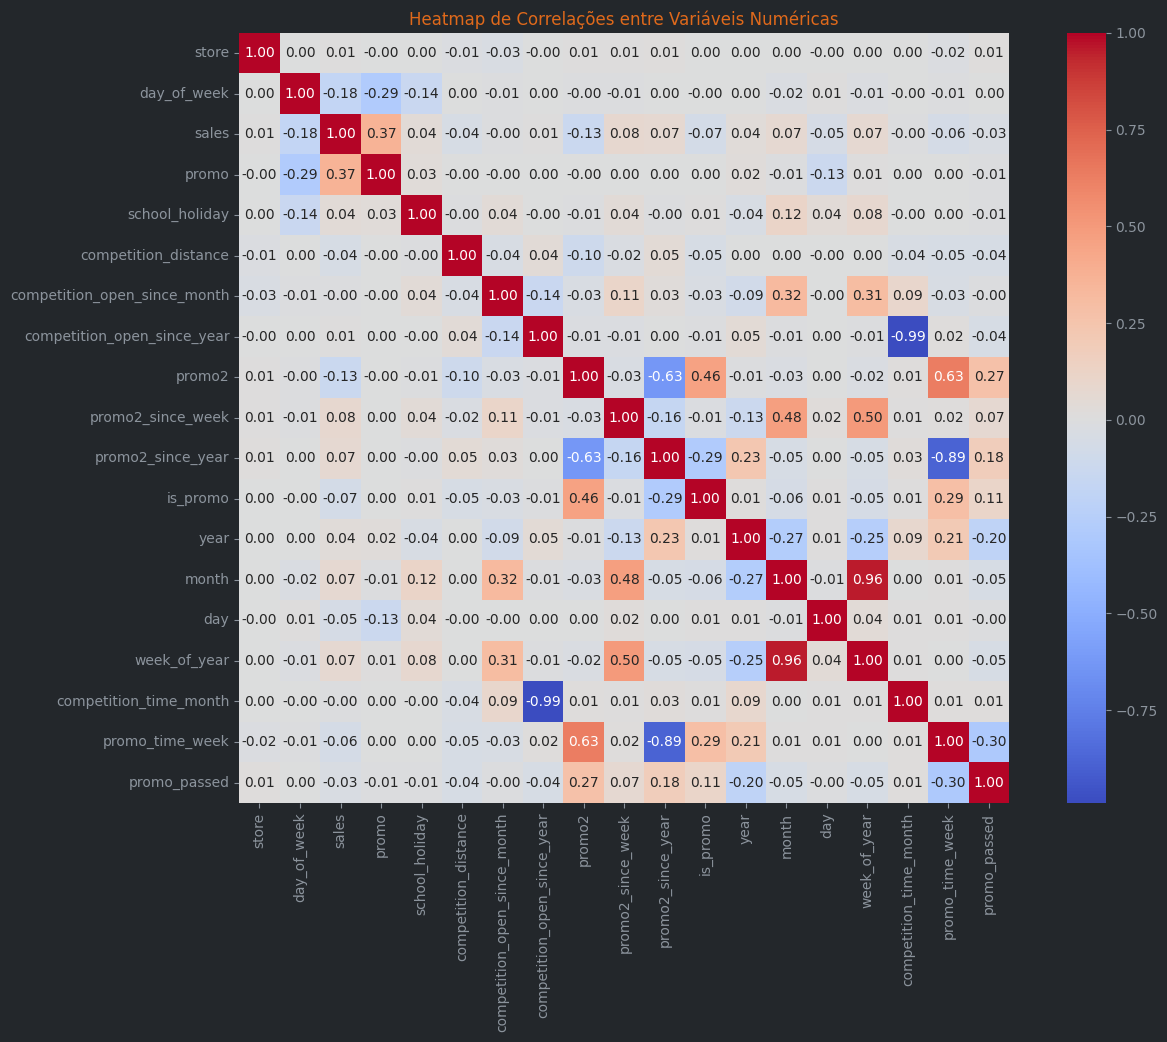

In [39]:
numeric_columns = df4.select_dtypes(include=['int64', 'float64'])

corr = numeric_columns.corr()

plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Heatmap de Correlações entre Variáveis Numéricas')
plt.show()


### 4.3.2 Categorical Attributes

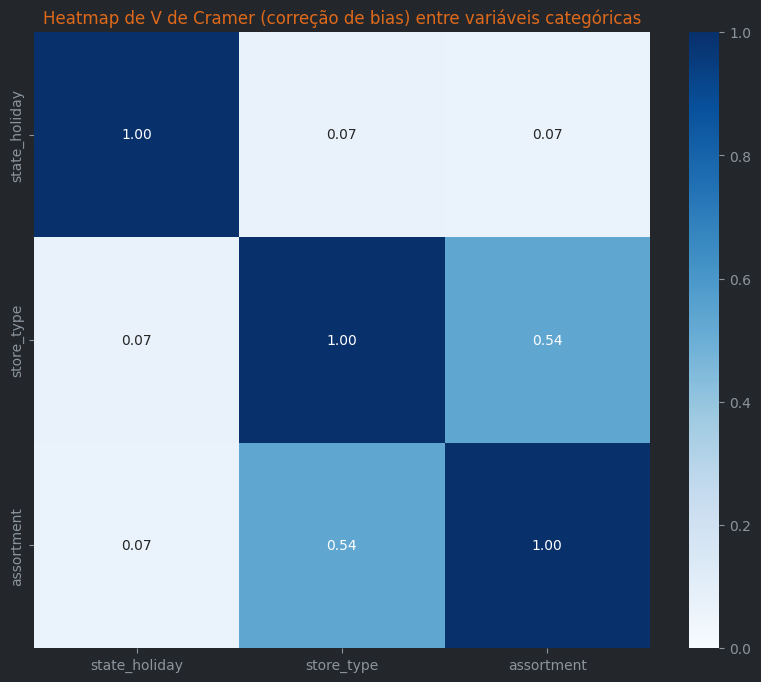

In [40]:
cat_cols = df4.select_dtypes(include=['object']).columns

cramers_results = pd.DataFrame(
    np.ones((len(cat_cols), len(cat_cols))),
    index=cat_cols,
    columns=cat_cols
)

for col1 in cat_cols:
    for col2 in cat_cols:
        if col1 == col2:
            cramers_results.loc[col1, col2] = 1.0
        else:
            confusion_matrix = pd.crosstab(df4[col1], df4[col2])
            if confusion_matrix.shape[0] > 1 and confusion_matrix.shape[1] > 1:
                cramers_results.loc[col1, col2] = cramers_v_bias_corrected(confusion_matrix)
            else:
                cramers_results.loc[col1, col2] = np.nan

plt.figure(figsize=(10,8))
sns.heatmap(cramers_results, annot=True, fmt='.2f', cmap='Blues', square=True, vmin=0, vmax=1)
plt.title("Heatmap de V de Cramer (correção de bias) entre variáveis categóricas")
plt.show()


### 4.3.3 Conclusão

Para esta análise, foram observadas as variáveis que possuem correlação alta entre elas, mas sem olhar de fato para variável resposta, buscando assim, notar quais variáveis serão ruído na generalização do modelo. Modelos com muitas variáveis são menos generálizaveis que aqueles com menos, portanto, é ideal manter a menor quantidade de variáveis possivel. Uma das maneiras de diminuir a quantidade de variáveis é vendo aquelas que passam a mesma "informação", ou seja, possuem uma correlação alta entre elas. 

Variáveis que podem passar a mesma informação são:

- promo_since_year e promo_since_week com promo_time_week.
- competition_since_month e competition_since_year com competition_time_month.

As variáveis tratam de tempo e foram geradas a partir da outra, no entanto, pode ser que o modelo seja prejudicado se mantermos todas. A primeiro momento, removerei as variáveis, e se caso as métricas forem baixas, voltarei para manter as variáveis, e testar novamente.

In [41]:
df4 = df4.drop(['promo2_since_year', 'promo2_since_week', 'competition_open_since_month', 'competition_open_since_year', 'competition_since', 'promo_since'], axis=1)


# 5.0 PREPARAÇÃO DE DADOS

In [42]:
df5 = df4

## 5.1 Rescaling

In [ ]:


mm_scaler = MinMaxScaler()
scaler = RobustScaler()

# Reescalando competition_distance
df5['competition_distance'] = scaler.fit_transform(df5[['competition_distance']])
with open('api/rossman/parameter/robust_scaler_competition_distance.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Reescalando competition_time_month
scaler2 = RobustScaler()
df5['competition_time_month'] = scaler2.fit_transform(df5[['competition_time_month']])
with open('api/rossman/parameter/robust_scaler_competition_time_month.pkl', 'wb') as f:
    pickle.dump(scaler2, f)

# Reescalando promo_time_week
mm_scaler_promo_time_week = MinMaxScaler()
df5['promo_time_week'] = mm_scaler_promo_time_week.fit_transform(df5[['promo_time_week']])
with open('api/rossman/parameter/minmax_scaler_promo_time_week.pkl', 'wb') as f:
    pickle.dump(mm_scaler_promo_time_week, f)

# Reescalando year
mm_scaler_year = MinMaxScaler()
df5['year'] = mm_scaler_year.fit_transform(df5[['year']])
with open('api/rossman/parameter/minmax_scaler_year.pkl', 'wb') as f:
    pickle.dump(mm_scaler_year, f)



## 5.2 Transformação

### 5.3.1 Encoding

In [ ]:

# OneHotEncoder para 'state_holiday'
ohe_state_holiday = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
state_holiday_encoded = ohe_state_holiday.fit_transform(df5[['state_holiday']])
state_holiday_columns = ohe_state_holiday.get_feature_names_out(['state_holiday'])
df_state_holiday = pd.DataFrame(state_holiday_encoded, columns=state_holiday_columns, index=df5.index)
df5 = pd.concat([df5.drop('state_holiday', axis=1), df_state_holiday], axis=1)
# Salvar o encoder em um pickle
with open('api/rossman/parameter/ohe_state_holiday.pkl', 'wb') as f:
    pickle.dump(ohe_state_holiday, f)

le_store_type = LabelEncoder()
df5['store_type_encoded'] = le_store_type.fit_transform(df5['store_type'])
# Salvar o encoder em um pickle
with open('api/rossman/parameter/le_store_type.pkl', 'wb') as f:
    pickle.dump(le_store_type, f)

assortment_mapping = {'basic': 0, 'extended': 2, 'extra': 1}
df5['assortment_encoded'] = df5['assortment'].map(assortment_mapping)

with open('api/rossman/parameter/assortment_mapping.pkl', 'wb') as f:
    pickle.dump(assortment_mapping, f)

df5 = df5.drop(['assortment', 'store_type'], axis=1)


### 5.3.2 Response Variable Transformation

In [45]:
df5['sales'] = np.log1p(df5['sales'])


In [46]:
# Transformação de seno e cosseno para a variável cíclica 'month'
df5['month_sin'] = np.sin(2 * np.pi * df5['month'] / 12)
df5['month_cos'] = np.cos(2 * np.pi * df5['month'] / 12)
df5 = df5.drop('month', axis=1)

# Transformação de seno e cosseno para a variável cíclica 'day'
df5['day_sin'] = np.sin(2 * np.pi * df5['day'] / 31)
df5['day_cos'] = np.cos(2 * np.pi * df5['day'] / 31)
df5 = df5.drop('day', axis=1)

# Transformação de seno e cosseno para a variável cíclica 'day_of_week'
df5['day_of_week_sin'] = np.sin(2 * np.pi * df5['day_of_week'] / 7)
df5['day_of_week_cos'] = np.cos(2 * np.pi * df5['day_of_week'] / 7)
df5 = df5.drop('day_of_week', axis=1)

# Transformação de seno e cosseno para a variável cíclica 'week_of_year'
df5['week_of_year_sin'] = np.sin(2 * np.pi * df5['week_of_year'] / 52)
df5['week_of_year_cos'] = np.cos(2 * np.pi * df5['week_of_year'] / 52)
df5 = df5.drop('week_of_year', axis=1)



# 6.0 Feature Selection

In [47]:
df6 = df5

## 6.1 Split dataframe into training and test dataset

In [48]:
df6_sorted = df6.sort_values('date')

# Descobrir a última data disponível
last_date = df6_sorted['date'].max()
first_test_date = last_date - pd.Timedelta(weeks=6)

# Definir conjunto de teste e treino
test_mask = df6_sorted['date'] > first_test_date

X = df6_sorted.drop(['sales'], axis=1)
y = df6_sorted['sales']

X_train = X[~test_mask].drop('date', axis=1)
y_train = y[~test_mask]
X_test_date = X[test_mask]
X_test = X[test_mask].drop('date', axis=1)
y_test = y[test_mask]


In [49]:
# Mostrar a data máxima e mínima do X_train
print("X_train: data máxima =", df6_sorted[~test_mask]['date'].max())
print("X_train: data mínima =", df6_sorted[~test_mask]['date'].min())

# Mostrar a data máxima e mínima do X_test
print("X_test: data máxima =", df6_sorted[test_mask]['date'].max())
print("X_test: data mínima =", df6_sorted[test_mask]['date'].min())


X_train: data máxima = 2015-06-19 00:00:00
X_train: data mínima = 2013-01-01 00:00:00
X_test: data máxima = 2015-07-31 00:00:00
X_test: data mínima = 2015-06-20 00:00:00


## 6.2 Boruta as Feature Selector

In [170]:

# Inicializar o modelo RandomForestRegressor como estimador base para o Boruta
rf = RandomForestRegressor()

# Inicializar o Boruta, lembrando que neste caso (regressão) precisa do parâmetro regression=True
boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)

# Executar o Boruta
boruta_selector.fit(X_train.values, y_train.values)

# Selecionar as features suportadas pelo Boruta
selected_features = X_train.columns[boruta_selector.support_].tolist()

print('Features selecionadas pelo Boruta:')
for feat in selected_features:
    print(feat)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	24
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	14
Tentative: 	0
Rejected: 	10


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	14
Tentative: 	0
Rejected: 	10
Features selecionadas pelo Boruta:
store
promo
competition_distance
promo2
competition_time_month
promo_time_week
store_type_encoded
assortment_encoded
month_cos
day_sin
day_cos
day_of_week_sin
day_of_week_cos
week_of_year_cos


## 6.3 Manual Feature Selection

In [50]:
selected_features_manual = [
    'store',
    'promo',
    'competition_distance',
    'promo2',
    'competition_time_month',
    'promo_time_week',
    'store_type_encoded',
    'assortment_encoded',
    'month_cos',
    'month_sin',
    'day_sin',
    'day_cos',
    'day_of_week_sin',
    'day_of_week_cos',
    'week_of_year_sin',
    'week_of_year_cos', 
    'date',
    'sales',
]

In [51]:
df6 = df6[selected_features_manual]


# 7.0 MACHINE LEARNING MODELLING

In [52]:
df7 = df6

In [53]:
df7_sorted = df7.sort_values('date')

# Descobrir a última data disponível
last_date = df7_sorted['date'].max()
first_test_date = last_date - pd.Timedelta(weeks=6)

# Definir conjunto de teste e treino
test_mask = df7_sorted['date'] > first_test_date

X = df7_sorted.drop(['sales'], axis=1)
y = df7_sorted['sales']

X_train = X[~test_mask].drop('date', axis=1)
y_train = y[~test_mask]
X_test = X[test_mask].drop('date', axis=1)
y_test = y[test_mask]

## 7.1 Average Model

In [54]:
# Calcula a média das vendas (em log) por loja (store) usando apenas o conjunto de treino
sales_mean_train = X_train.copy()
sales_mean_train['sales'] = y_train
sales_mean_per_store = sales_mean_train.groupby('store')['sales'].mean()

# Gera as previsões para o conjunto de teste atribuindo a média para cada store do teste
stores_test = X_test['store']
y_pred_avg = stores_test.map(sales_mean_per_store).values

# Corrige o tamanho de y_test para garantir alinhamento
y_test_array = y_test.values

# Rescale para o domínio original
y_test_rescaled = np.expm1(y_test_array)
y_pred_avg_rescaled = np.expm1(y_pred_avg)

df_metrics_avg = calcular_metricas(y_test_rescaled, y_pred_avg_rescaled, 'Average_model')
df_metrics_avg




,modelo,rmse,mae,mape,r2
0,Average_model,1954.630847,1440.845833,21.911805,0.590551


## 7.2 Linear Regression Model


In [56]:

# Treina o modelo de Regressão Linear
lr = LinearRegression()
lr.fit(X_train, y_train)

# Faz previsões no conjunto de teste
y_pred_lr = lr.predict(X_test)

# Rescale para o domínio original
y_test_rescaled = np.expm1(y_test_array)
y_pred_lr_rescaled = np.expm1(y_pred_lr)

# Calcula as métricas de avaliação
df_metrics_lr = calcular_metricas(y_test_rescaled, y_pred_lr_rescaled, 'LinearRegression')
df_metrics_lr


,modelo,rmse,mae,mape,r2
0,LinearRegression,2731.949391,1879.299786,28.559134,0.200138


## 7.3 Linear Regression Regularized Model - Lasso

In [ ]:
# Instancia e treina o Lasso
lasso = Lasso(alpha=0.01, random_state=42)
lasso.fit(X_train, y_train)

# Faz previsões
y_pred_lasso = lasso.predict(X_test)

# Rescale para o domínio original
y_test_rescaled = np.expm1(y_test_array)
y_pred_lasso_rescaled = np.expm1(y_pred_lasso)

# Calcula as métricas
df_metrics_lasso = calcular_metricas(y_test_rescaled, y_pred_lasso_rescaled, 'Lasso')
df_metrics_lasso


,modelo,rmse,mae,mape,r2
0,Lasso,2773.645286,1902.867814,28.973483,0.175536


## 7.4 Linear Regression Regularized Model - Ridge

In [ ]:
# Instancia e treina o Ridge
ridge = Ridge(alpha=0.01, random_state=42)
ridge.fit(X_train, y_train)

# Faz previsões
y_pred_ridge = ridge.predict(X_test)

# Rescale para o domínio original
y_test_rescaled = np.expm1(y_test_array)
y_pred_ridge_rescaled = np.expm1(y_pred_ridge)

# Calcula as métricas
df_metrics_ridge = calcular_metricas(y_test_rescaled, y_pred_ridge_rescaled, 'Ridge')
df_metrics_ridge


,modelo,rmse,mae,mape,r2
0,Ridge,2731.949415,1879.299795,28.559133,0.200138


## 7.5 Random Forest Regressor

In [59]:
# Instancia e treina o Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Faz previsões
y_pred_rf = rf.predict(X_test)

# Rescale para o domínio original
y_test_rescaled = np.expm1(y_test_array)
y_pred_rf_rescaled = np.expm1(y_pred_rf)

# Calcula as métricas
df_metrics_rf = calcular_metricas(y_test_rescaled, y_pred_rf_rescaled, 'RandomForest')
df_metrics_rf


,modelo,rmse,mae,mape,r2
0,RandomForest,1081.927477,719.942672,10.630723,0.874551


## 7.6 XGBoost Regressor

In [60]:

xgbr = XGBRegressor(
    n_estimators=2000,
    eta=0.01,
    max_depth=10,
    subsample=0.7,
    colsample_bytree=0.9,
    objective='reg:squarederror'
)

xgbr.fit(X_train, y_train)

# Faz previsões
y_pred_xgb = xgbr.predict(X_test)

# Rescale para o domínio original
y_test_rescaled = np.expm1(y_test_array)
y_pred_xgb_rescaled = np.expm1(y_pred_xgb)

# Calcula as métricas
df_metrics_xgb = calcular_metricas(y_test_rescaled, y_pred_xgb_rescaled, 'XGBoost')
df_metrics_xgb




,modelo,rmse,mae,mape,r2
0,XGBoost,1110.322697,746.603666,10.614738,0.86788


## 7.7 Compare Model's Performance

In [61]:
df_metricas_totais = pd.concat([
    df_metrics_avg,
    df_metrics_lr,
    df_metrics_lasso,
    df_metrics_ridge,
    df_metrics_rf,
    df_metrics_xgb
], ignore_index=True)
df_metricas_totais = df_metricas_totais.sort_values(by='r2', ascending=False).reset_index(drop=True)
df_metricas_totais

,modelo,rmse,mae,mape,r2
0,RandomForest,1081.927477,719.942672,10.630723,0.874551
1,XGBoost,1110.322697,746.603666,10.614738,0.867880
2,Average_model,1954.630847,1440.845833,21.911805,0.590551
3,LinearRegression,2731.949391,1879.299786,28.559134,0.200138
4,Ridge,2731.949415,1879.299795,28.559133,0.200138
5,Lasso,2773.645286,1902.867814,28.973483,0.175536


## 7.8 Cross Validation

### 7.8.1 RandomForest Regressor

In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

rf_resultados = cross_validation(df7, 5, 'RandomForest', rf, verbose=False)

In [ ]:
rf_resultados

,Model Name,MAE CV,MAPE CV,RMSE CV,R2 CV
0,RandomForest,772.61 +/- 114.09,11.19 +/- 1.59,1161.06 +/- 163.19,0.8492 +/- 0.0358


### 7.8.1 XGboostRegressor

In [71]:
xgbr = XGBRegressor(
    n_estimators=2000,
    eta=0.01,
    max_depth=10,
    subsample=0.7,
    colsample_bytree=0.9,
    objective='reg:squarederror'
)

xgbr_resultados = cross_validation(df7, 5, 'XgboostRegressor', xgbr, verbose=False)

In [72]:
xgbr_resultados

,Model Name,MAE CV,MAPE CV,RMSE CV,R2 CV
0,XgboostRegressor,832.4 +/- 111.3,11.77 +/- 0.89,1216.33 +/- 164.58,0.8365 +/- 0.0261


## 7.9 Conclusões

Para aplicação do modelo de machine learning, foi escolhido o modelo Xgboost regressor, pois, além de ser mais leve em questão de armazenamento que uma RandomForest, apresentou valores de erro baixos e próximos da própria RandomForest.

# 8.0 FINE TUNING

In [57]:
df8 = df7

## 8.1 Utilizando a busca bayesiana

In [ ]:

# Espaço de busca para busca bayesiana
param_search = {
    'n_estimators': Integer(500, 3000),
    'max_depth': Integer(3, 15),
    'learning_rate': Real(0.005, 0.105, prior='uniform'),
    'subsample': Real(0.6, 1.0, prior='uniform'),
    'colsample_bytree': Real(0.6, 1.0, prior='uniform'),
    'gamma': Real(0.0, 0.3, prior='uniform'),
    'min_child_weight': Integer(1, 10)
}

xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)


bayes_search = BayesSearchCV(
    estimator=xgb_reg,
    search_spaces=param_search,
    n_iter=30,
    scoring='r2',
    n_jobs=1,
    cv=3,
    verbose=2,
    random_state=42
)


X = df8.drop(['sales', 'date'], axis=1)
y = df8['sales']

bayes_search.fit(X, y)
 
print("Melhores parâmetros encontrados:", bayes_search.best_params_)
print("Melhor R²:", bayes_search.best_score_)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END colsample_bytree=0.7640415835413256, gamma=0.2183177229531975, learning_rate=0.09828679988478338, max_depth=7, min_child_weight=7, n_estimators=1535, subsample=0.7403725339596576; total time=  24.1s
[CV] END colsample_bytree=0.7640415835413256, gamma=0.2183177229531975, learning_rate=0.09828679988478338, max_depth=7, min_child_weight=7, n_estimators=1535, subsample=0.7403725339596576; total time=  20.9s
[CV] END colsample_bytree=0.7640415835413256, gamma=0.2183177229531975, learning_rate=0.09828679988478338, max_depth=7, min_child_weight=7, n_estimators=1535, subsample=0.7403725339596576; total time=  20.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END colsample_bytree=0.9349553422213137, gamma=0.26499458321425867, learning_rate=0.03534101098841749, max_depth=14, min_child_weight=9, n_estimators=656, subsample=0.65532341531143; total time=  16.8s
[CV] END colsample_bytree=0.9349553422213137, gamma

## 8.2 Comparando os modelos

In [60]:

expected_features = [
    'store',
    'promo',
    'competition_distance',
    'promo2',
    'competition_time_month',
    'promo_time_week',
    'month_cos',
    'month_sin',
    'day_sin',
    'day_cos',
    'day_of_week_sin',
    'day_of_week_cos',
    'week_of_year_sin',
    'week_of_year_cos',
    'store_type_encoded',
    'assortment_encoded'
]

melhores_params = {
    'colsample_bytree': 1.0,
    'gamma': 0.0,
    'learning_rate': 0.026411802377262334,
    'max_depth': 10,
    'min_child_weight': 2,
    'n_estimators': 3000,
    'subsample': 0.6
}

xgb_best = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    **melhores_params
)

# Garantir que os dados de treino e teste possuam somente as colunas esperadas
X_train_sel = X_train[expected_features]
X_test_sel = X_test[expected_features]

# Treina e avalia sobre X_train_sel, y_train e X_test_sel, y_test já previamente definidos
xgb_best.fit(X_train_sel, y_train)

y_test_pred = xgb_best.predict(X_test_sel)
y_test_array = y_test.values

# Rescale para o domínio original
y_test_rescaled = np.expm1(y_test_array)
y_pred_rescaled = np.expm1(y_test_pred)

df_metrics_avg = calcular_metricas(y_test_rescaled, y_pred_rescaled, 'xgb_best_model')
df_metrics_avg


,modelo,rmse,mae,mape,r2
0,xgb_best_model,1010.367215,684.890769,9.680557,0.890597


In [61]:
mpe = mean_percentage_error(y_test_rescaled, y_pred_rescaled)
print(f'MPE do modelo XGBRegressor : {mpe:.2f}%')


MPE do modelo XGBRegressor : 2.64%


Houve um aumento de 2.32% no R2, uma diminuição de 63.27 no MAE, 0.95 no MAPE e 102.509 no RMSE, e o modelo tende a superestimar.

## 8.3 Treinando o modelo com todo o conjunto de dados.

In [62]:
# Treinando o modelo com todo o conjunto de dados utilizando os melhores hiperparâmetros encontrados

melhores_params = {
    'colsample_bytree': 1.0,
    'gamma': 0.0,
    'learning_rate': 0.026411802377262334,
    'max_depth': 10,
    'min_child_weight': 2,
    'n_estimators': 3000,
    'subsample': 0.6
}

xgb_best = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    **melhores_params
)

X = df8[expected_features]
y = df8['sales']

# Treinar o modelo com todos os dados
xgb_best.fit(X, y)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1.0
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


# 9.0 TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [63]:
df9 = df8
df9['sales'] = np.expm1(df9['sales'])


C:\Users\Patryck\AppData\Local\Temp\ipykernel_5356\289166527.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1(df9['sales'])


## 9.1 Bussiness Performance

In [64]:
y_test_rescaled_series = pd.Series(y_test_rescaled, index=X_test_date.index, name='sales')
df_test = pd.concat([X_test_date.reset_index(drop=True), y_test_rescaled_series.reset_index(drop=True)], axis=1)
y_pred_rescaled = np.expm1(y_test_pred)
df_test['prediction'] = y_pred_rescaled


In [65]:
aux1 = df_test[['store', 'prediction']].copy()
aux1 = aux1.groupby('store')[['prediction']].sum().reset_index()

# Calculando MAE e MAPE por loja
sales_sum = df_test.groupby('store')['sales'].sum().reset_index()
aux1 = aux1.merge(sales_sum, on='store')
aux1['mae'] = np.abs(aux1['sales'] - aux1['prediction'])
aux1['mape'] = np.abs((aux1['sales'] - aux1['prediction']) / aux1['sales']) * 100

# Calculando worst/best case scenario
aux1['worst_case'] = aux1['prediction'] - aux1['mae']
aux1['best_case'] = aux1['prediction'] + aux1['mae']

# Drop sales da tabela final
aux1 = aux1.drop(columns=['sales'])

### 9.1.1 Erros Mae e Mape por loja

In [66]:
aux1.head()

,store,prediction,mae,mape,worst_case,best_case
0,1,152861.843750,5256.156250,3.324199,147605.6875,158118.00000
1,2,192605.796875,14595.796875,8.199425,178010.0000,207201.59375
2,3,255487.093750,9371.093750,3.807592,246116.0000,264858.18750
3,4,320904.031250,38787.968750,10.783662,282116.0625,359692.00000
4,5,171079.546875,9885.546875,6.132702,161194.0000,180965.09375


### 9.1.2 Lojas mais desafiadoras de se prever

In [67]:
aux1_sorted = aux1.sort_values(by='mape', ascending=False).reset_index(drop=True)
aux1_sorted.head()


,store,prediction,mae,mape,worst_case,best_case
0,909,221794.140625,126418.859375,36.305037,95375.281250,348213.00000
1,550,238072.578125,51989.578125,27.938919,186083.000000,290062.15625
2,292,96602.820312,35307.179687,26.766113,61295.640625,131910.00000
3,688,160904.140625,32784.140625,25.588621,128120.000000,193688.28125
4,876,184458.718750,63176.281250,25.511855,121282.437500,247635.00000


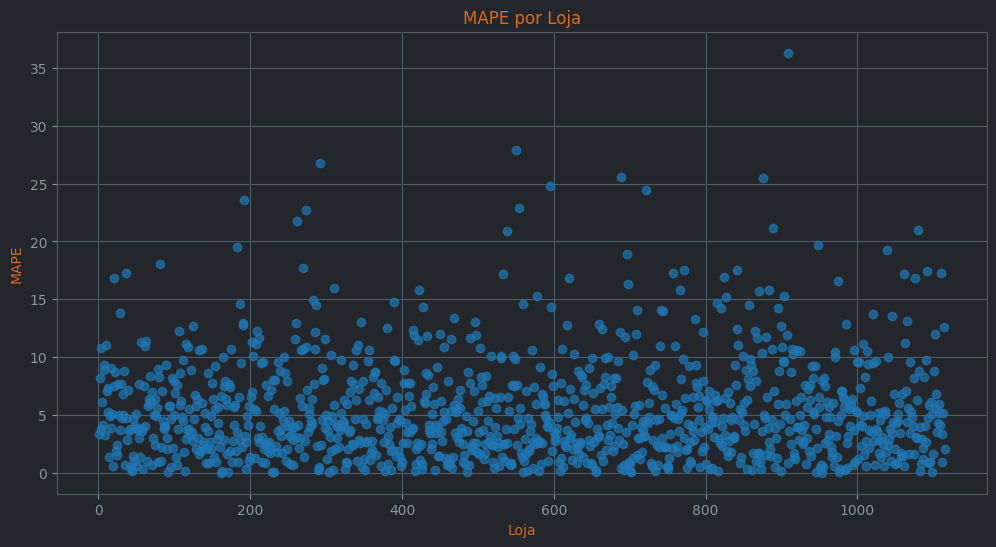

In [68]:
plt.figure(figsize=(12,6))
plt.scatter(aux1['store'], aux1['mape'], alpha=0.7)
plt.xlabel('Loja')
plt.ylabel('MAPE')
plt.title('MAPE por Loja')
plt.grid(True)
plt.show()


## 9.2 Total Perfomance

In [69]:
scenarios_df = pd.DataFrame({
    'scenario': ['predictions', 'worst scenario', 'best scenario'],
    'values': [
        f"${aux1['prediction'].sum():,.2f}",
        f"${aux1['worst_case'].sum():,.2f}",
        f"${aux1['best_case'].sum():,.2f}"
    ]
})

scenarios_df

,scenario,values
0,predictions,"$268,632,896.00"
1,worst scenario,"$252,230,178.91"
2,best scenario,"$285,035,610.94"


## 9.3 Machine Learning Perfomance

In [70]:
df_test['error'] = df_test['sales'] - df_test['prediction']
df_test['error_rate'] = df_test['prediction'] / df_test['sales']

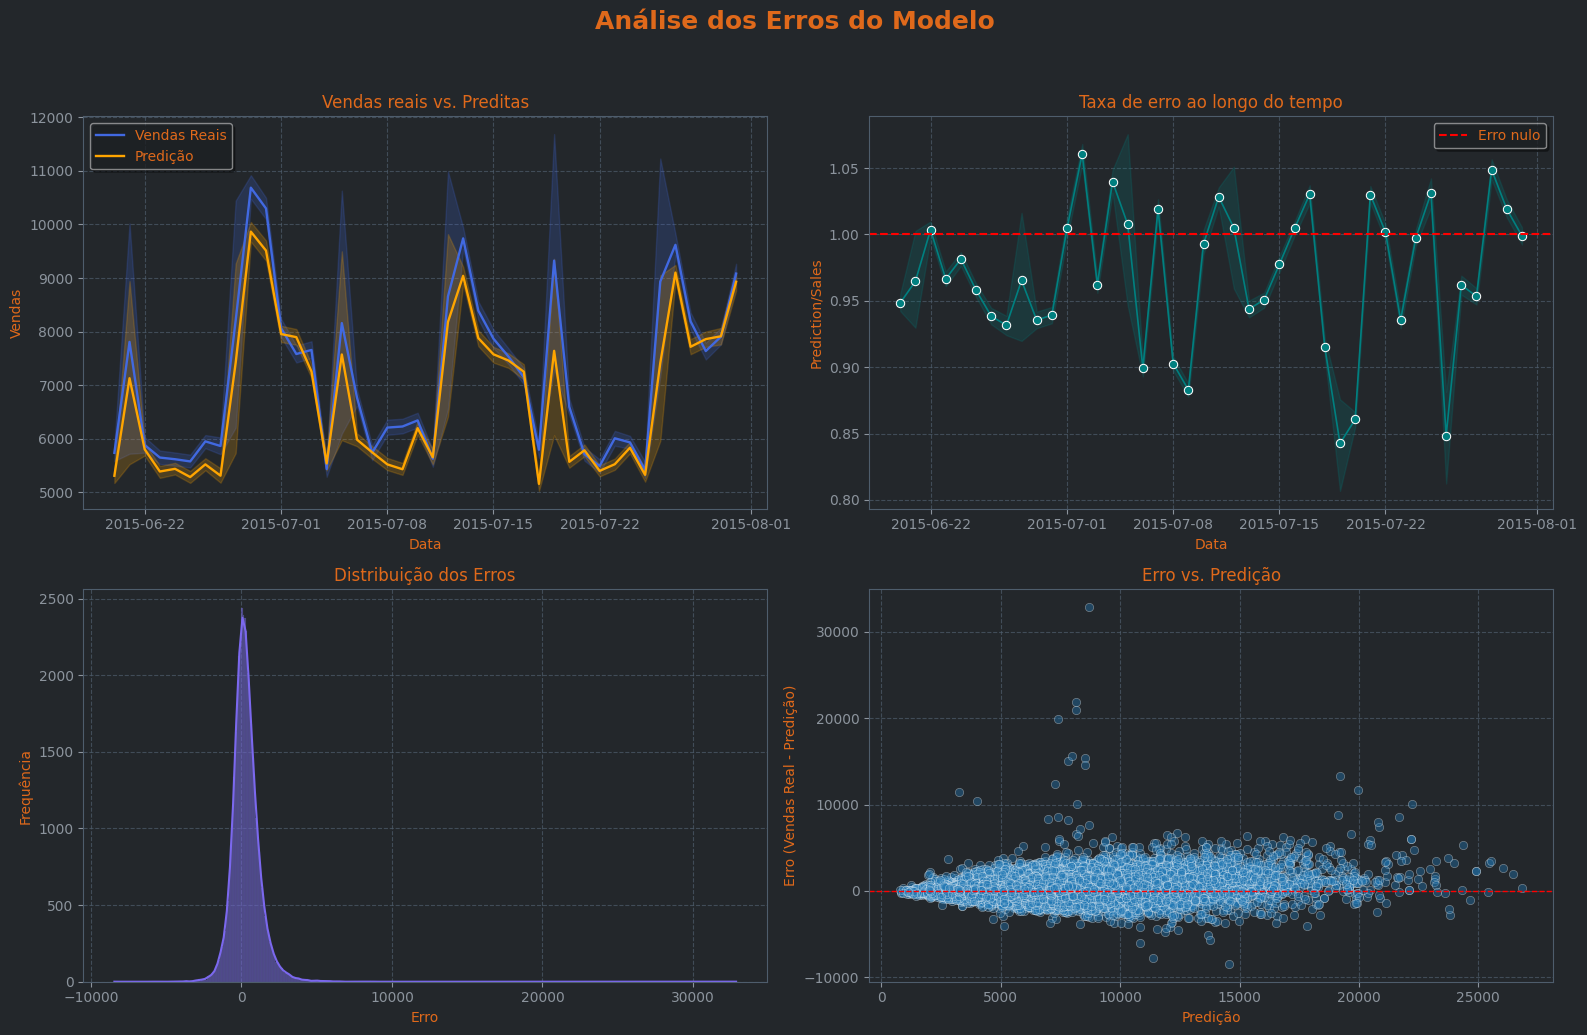

In [71]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

sns.lineplot(x='date', y='sales', data=df_test, label='Vendas Reais', ax=axes[0,0], color='royalblue', linewidth=1.7)
sns.lineplot(x='date', y='prediction', data=df_test, label='Predição', ax=axes[0,0], color='orange', linewidth=1.7)
axes[0,0].set_title('Vendas reais vs. Preditas')
axes[0,0].set_xlabel('Data')
axes[0,0].set_ylabel('Vendas')
axes[0,0].legend()
axes[0,0].grid(linestyle='--', alpha=0.7)

sns.lineplot(x='date', y='error_rate', data=df_test, marker='o', ax=axes[0,1], color='teal', linewidth=1.2)
axes[0,1].axhline(1, linestyle='--', color='red', label='Erro nulo')
axes[0,1].set_title('Taxa de erro ao longo do tempo')
axes[0,1].set_xlabel('Data')
axes[0,1].set_ylabel('Prediction/Sales')
axes[0,1].legend()
axes[0,1].grid(linestyle='--', alpha=0.7)

sns.histplot(df_test['error'], kde=True, color='mediumslateblue', ax=axes[1,0])
axes[1,0].set_title('Distribuição dos Erros')
axes[1,0].set_xlabel('Erro')
axes[1,0].set_ylabel('Frequência')
axes[1,0].grid(linestyle='--', alpha=0.7)

sns.scatterplot(x='prediction', y='error', data=df_test, ax=axes[1,1], alpha=0.4)
axes[1,1].axhline(0, color='red', linestyle='--', linewidth=1)
axes[1,1].set_title('Erro vs. Predição')
axes[1,1].set_xlabel('Predição')
axes[1,1].set_ylabel('Erro (Vendas Real - Predição)')
axes[1,1].grid(linestyle='--', alpha=0.7)

plt.suptitle('Análise dos Erros do Modelo', fontsize=18, y=1.03, fontweight='bold')
plt.tight_layout()
plt.show()

# 10.0 DEPLOY DO MODELO PARA PRODUÇÂO

## 10.1 Salvando o modelo

In [73]:
with open('api/rossman/model/model_rossman_sales.pkl', 'wb') as f:
    pickle.dump(xgb_best, f)


## 10.2 Pipeline de dados

In [74]:
import pickle
import pandas as pd
import numpy as np
import datetime

class Rossman:
    """
    Classe principal para gerenciamento do modelo Rossman, incluindo limpeza de dados,
    engenharia de atributos, preparação dos dados e predição.

    Esta classe encapsula todo o pipeline de preparação e inferência, utilizando os mesmos 
    scalers e encoders salvos durante o treinamento para garantir consistência no deploy.
    """

    # Lista das features esperadas pelo modelo treinado
    expected_features = [
        'store',
        'promo',
        'competition_distance',
        'promo2',
        'competition_time_month',
        'promo_time_week',
        'month_cos',
        'month_sin',
        'day_sin',
        'day_cos',
        'day_of_week_sin',
        'day_of_week_cos',
        'week_of_year_sin',
        'week_of_year_cos',
        'store_type_encoded',
        'assortment_encoded'
    ]

    def __init__(self):
        with open('parameter/robust_scaler_competition_distance.pkl', 'rb') as f:
            self.scaler_competition_distance = pickle.load(f)
        with open('parameter/robust_scaler_competition_time_month.pkl', 'rb') as f:
            self.scaler_competition_time_month = pickle.load(f)
        with open('parameter/minmax_scaler_promo_time_week.pkl', 'rb') as f:
            self.scaler_promo_time_week = pickle.load(f)
        with open('parameter/minmax_scaler_year.pkl', 'rb') as f:
            self.scaler_year = pickle.load(f)
        with open('parameter/ohe_state_holiday.pkl', 'rb') as f:
            self.ohe_state_holiday = pickle.load(f)
        with open('parameter/le_store_type.pkl', 'rb') as f:
            self.le_store_type = pickle.load(f)
        with open('parameter/assortment_mapping.pkl', 'rb') as f:
            self.assortment_mapping = pickle.load(f)
        # Carrega o modelo treinado
        with open('model/model_rossman_sales.pkl', 'rb') as f:
            self.model = pickle.load(f)
        
    def clean_data(self, df):
        df = df.copy()
        def snake_case(lst):
            def convert(s):
                s = s.replace(' ', '_')
                new_s = ""
                for i, c in enumerate(s):
                    if c.isupper():
                        if i > 0 and (s[i-1].islower() or (i+1 < len(s) and s[i+1].islower())):
                            new_s += "_"
                        new_s += c.lower()
                    else:
                        new_s += c
                return new_s
            return [convert(s) for s in lst]
        df.columns = snake_case(df.columns)
        df['date'] = pd.to_datetime(df['date'])
        df['competition_distance'] = df['competition_distance'].fillna(200000)
        df['competition_open_since_month'] = df['competition_open_since_month'].fillna(df['date'].dt.month)
        df['competition_open_since_year'] = df['competition_open_since_year'].fillna(df['date'].dt.year)
        df['promo2_since_week'] = df['promo2_since_week'].fillna(df['date'].dt.isocalendar().week)
        df['promo2_since_year'] = df['promo2_since_year'].fillna(df['date'].dt.year)
        df['promo_interval'] = df['promo_interval'].fillna(0)
        df['competition_open_since_month'] = df['competition_open_since_month'].astype(int)
        df['competition_open_since_year'] = df['competition_open_since_year'].astype(int)
        df['promo2_since_week'] = df['promo2_since_week'].astype(int)
        df['promo2_since_year'] = df['promo2_since_year'].astype(int)
        return df

    def feature_engineering(self, df):
        df = df.copy()
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        df['month_map'] = df['date'].dt.month.map(month_map)
        df['is_promo'] = df.apply(lambda row: 1 if str(row['month_map']) in str(row['promo_interval']) else 0, axis=1)
        df.drop('month_map', axis=1, inplace=True)
        df['year'] = df['date'].dt.year.astype(int)
        df['month'] = df['date'].dt.month.astype(int)
        df['day'] = df['date'].dt.day.astype(int)
        df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)
        df['competition_since'] = pd.to_datetime(
            dict(year=df['competition_open_since_year'],
                 month=df['competition_open_since_month'],
                 day=1)
        )
        df['competition_time_month'] = ((df['date'] - df['competition_since']).dt.days / 30).round().astype(int)
        df['promo_since'] = df['promo2_since_year'].astype(str) + '-' + df['promo2_since_week'].astype(str)
        df['promo_since'] = df['promo_since'].apply(
            lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7)
        )
        df['promo_time_week'] = ((df['date'] - df['promo_since']) / 7).apply(lambda x: x.days).astype(int)
        if 'assortment' in df.columns:
            df['assortment'] = df['assortment'].map({'a': 'basic', 'b': 'extra', 'c': 'extended'})
        if 'state_holiday' in df.columns:
            df['state_holiday'] = df['state_holiday'].map(
                {'a': 'public holiday', 'b': 'easter holiday', 'c': 'christmas', '0': 'regular_day'}
            )
        if 'month_cos' not in df.columns:
            df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
        if 'month_sin' not in df.columns:
            df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
        if 'day_cos' not in df.columns:
            df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
        if 'day_sin' not in df.columns:
            df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
        if 'day_of_week' in df.columns:
            if 'day_of_week_cos' not in df.columns:
                df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
            if 'day_of_week_sin' not in df.columns:
                df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
        if 'week_of_year_cos' not in df.columns:
            df['week_of_year_cos'] = np.cos(2 * np.pi * df['week_of_year'] / 52)
        if 'week_of_year_sin' not in df.columns:
            df['week_of_year_sin'] = np.sin(2 * np.pi * df['week_of_year'] / 52)
        drop_cols = [
            'customers',
            'open',
            'promo_interval',
            'promo2_since_year',
            'promo2_since_week',
            'competition_open_since_month',
            'competition_open_since_year',
            'competition_since',
            'promo_since'
        ]
        drop_cols = [col for col in drop_cols if col in df.columns]
        if drop_cols:
            df = df.drop(drop_cols, axis=1)
        return df

    def data_preparation(self, df):
        df = df.copy()
        if 'competition_distance' in df.columns:
            df['competition_distance'] = self.scaler_competition_distance.transform(df[['competition_distance']])
        if 'competition_time_month' in df.columns:
            df['competition_time_month'] = self.scaler_competition_time_month.transform(df[['competition_time_month']])
        if 'promo_time_week' in df.columns:
            df['promo_time_week'] = self.scaler_promo_time_week.transform(df[['promo_time_week']])
        if 'year' in df.columns:
            df['year'] = self.scaler_year.transform(df[['year']])
        if 'state_holiday' in df.columns:
            state_holiday_encoded = self.ohe_state_holiday.transform(df[['state_holiday']])
            state_holiday_columns = self.ohe_state_holiday.get_feature_names_out(['state_holiday'])
            df_state_holiday = pd.DataFrame(state_holiday_encoded, columns=state_holiday_columns, index=df.index)
            df = pd.concat([df.drop('state_holiday', axis=1), df_state_holiday], axis=1)
        if 'store_type' in df.columns:
            df['store_type_encoded'] = self.le_store_type.transform(df['store_type'])
        if 'assortment' in df.columns:
            df['assortment_encoded'] = df['assortment'].map(self.assortment_mapping)
        drop_cats = [c for c in ['assortment', 'store_type'] if c in df.columns]
        if drop_cats:
            df = df.drop(drop_cats, axis=1)
        missing_cols = [col for col in self.expected_features if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Missing expected features: {missing_cols}")
        df = df[self.expected_features]
        return df

    def predict(self, df):
        """
        Executa o pipeline completo: limpeza, feature engineering, preparação dos dados e retorna as predições em um DataFrame.
        
        Parâmetros:
        ----------
        df : pd.DataFrame
            DataFrame bruto de entrada.

        Retorno:
        -------
        df_predictions : pd.DataFrame
            DataFrame com os valores previstos de vendas para as amostras fornecidas.
        """
        # Limpa os dados
        df_clean = self.clean_data(df)
        # Engenharia de features
        df_feat = self.feature_engineering(df_clean)
        # Prepara os dados para o modelo
        df_ready = self.data_preparation(df_feat)
        # Faz predição
        preds = self.model.predict(df_ready)
        preds_exp = np.expm1(preds)
        df['prediction'] = preds_exp
        return df



## 10.3 API Handler

In [62]:
import pandas as pd
from flask import Flask, request, Response
import os

app = Flask(__name__)

@app.route('/rossman/predict', methods=['POST'])
def rossman_predict():
    test_json = request.get_json()

    if test_json:

        if isinstance(test_json, dict):
            df = pd.DataFrame(test_json, index=[0]) 
        else:
            df = pd.DataFrame(test_json, columns=test_json[0].keys())

        pipeline = Rossman()

        df_predict = pipeline.predict(df)

        return Response(df_predict.to_json(orient='records'), status=200, mimetype='application/json')
        
    else: 
        return Response('{}', status=200, mimetype='application/json')


if __name__ == '__main__':
    port = int(os.environ.get("PORT", 5000))
    app.run('0.0.0.0', port=port)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.18.8:5000
Press CTRL+C to quit


## 10.4 API Test

In [1]:
import requests

In [6]:
df_test = pd.read_csv('database/test.csv')
df_test = df_test.merge(df_store_raw, how='left', on='Store')
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isna()]



In [7]:
df_test_json = df_test.to_json(orient='records')

In [ ]:
url = 'http://localhost:5000/rossman/predict'
header = {'Content-type': 'application/json'}
data = df_test_json

r = requests.post(url, data = data, headers = header)

In [10]:
r

<Response [500]>

In [9]:
df_final = pd.DataFrame(r.json())

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [259]:
df_final.head().T

,0,1,2,3,4
Id,1,2,3,4,5
Store,1,3,7,8,9
DayOfWeek,4,4,4,4,4
Date,2015-09-17,2015-09-17,2015-09-17,2015-09-17,2015-09-17
Open,1.0,1.0,1.0,1.0,1.0
Promo,1,1,1,1,1
StateHoliday,0,0,0,0,0
SchoolHoliday,0,0,0,0,0
StoreType,c,a,a,a,a
Assortment,a,a,c,a,c
